In [1]:
# Data framworks & processing
import pandas as pd
import numpy  as np
from datetime import datetime
import pickle as pkl
# Machine Learning Libraries
import lightgbm as lgb
import xgboost  as xgb

# sklearn tools for model training and parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Visualization Tools
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.pyplot as plt1
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# First, let's import requisite files
orders      = pd.read_csv('../Instacart_Input/orders.csv')
prior_set   = pd.read_csv('../Instacart_Input/order_products__prior.csv')
train_set   = pd.read_csv('../Instacart_Input/order_products__train.csv')
aisles      = pd.read_csv('../Instacart_Input/aisles.csv')
departments = pd.read_csv('../Instacart_Input/departments.csv')
products    = pd.read_csv('../Instacart_Input/products.csv')



In [18]:
orders.set_index('order_id', inplace=True, drop=False)
prior_set                       = prior_set.join(orders, on='order_id', rsuffix='_')
prior_set.drop('order_id_', inplace=True, axis=1)
prior_set                       = prior_set.merge(products,
                                                  on='product_id',
                                                  how='left')

print 'Processing user data...'
temp                            = pd.DataFrame()
temp['avg_days_since_usr']      = orders.groupby('user_id'
                                                )['days_since_prior_order'
                                                 ].mean().astype(np.float32)
temp['std_days_since_usr']      = orders.groupby('user_id'
                                                )['days_since_prior_order'
                                                 ].std().astype(np.float32)
temp['avg_usr_order_dow']       = orders.groupby('user_id'
                                                )['order_dow'
                                                 ].mean().astype(np.float32)
temp['std_usr_order_dow']       = orders.groupby('user_id'
                                                )['order_dow'
                                                 ].std().astype(np.float32)
temp['avg_usr_order_hod']       = orders.groupby('user_id'
                                                )['order_hour_of_day'
                                                 ].mean().astype(np.float32)
temp['std_usr_order_hod']       = orders.groupby('user_id'
                                                )['order_hour_of_day'
                                                 ].std().astype(np.float32)

temp['var_coef_days_since_usr'] = ( temp['std_days_since_usr']  / temp['avg_days_since_usr'] ).astype(np.float32)
temp['var_coef_dow']            = ( temp['std_usr_order_dow']   / temp['avg_usr_order_dow'] ).astype(np.float32)
temp['var_coef_hod']            = ( temp['std_usr_order_hod']   / temp['avg_usr_order_hod'] ).astype(np.float32)
temp['orders_prior']            = orders[orders['eval_set'] == 'prior'
                                        ].groupby('user_id').size().astype(np.int16)   

user_data = pd.DataFrame()
user_data['total_items']        = prior_set.groupby('user_id').size().astype(np.int16)
user_data['all_products']       = prior_set.groupby('user_id')['product_id'].apply(set)
user_data['all_depts']          = prior_set.groupby('user_id')['department_id'].apply(set)
user_data['all_aisles']         = prior_set.groupby('user_id')['aisle_id'].apply(set)
user_data['unique_depts']       = (user_data.all_depts.map(len)).astype(np.int16)
user_data['unique_aisles']      = (user_data.all_aisles.map(len)).astype(np.int16)
user_data['total_unique_items'] = (user_data.all_products.map(len)).astype(np.int16)
user_data                       = user_data.join(temp)
del temp

user_data['avg_basket_size']    = (user_data.total_items  / user_data.orders_prior
                                  ).astype(np.float32)
user_data['dept_ratio']         = (user_data.unique_depts / user_data.total_items
                                  ).astype(np.float32)
user_data['aisle_ratio']        = (user_data.unique_aisles/ user_data.total_items
                                  ).astype(np.float32)

user_data.reset_index(inplace=True)


print 'Processing aisle, department, & time-series data for reference later...'
user_departments                = pd.DataFrame(prior_set.groupby(['user_id',
                                                                  'department_id']
                                                                ).size()).reset_index()
user_aisles                     = pd.DataFrame(prior_set.groupby(['user_id',
                                                                  'aisle_id']
                                                                ).size()).reset_index()

totals                          = user_departments.groupby('user_id').sum().reset_index()
totals.rename(columns           ={0 :'totaldepts'}, inplace=True)
totals                          = totals.drop(['department_id'], axis=1)

user_departments.rename(columns ={0 :'dept_instances'}, inplace=True)
user_departments                = user_departments.merge(totals,
                                                         on='user_id',
                                                         how='left'
                                                        )
user_departments['dept_frequency']= (user_departments['dept_instances'] / user_departments['totaldepts']
                                     ).astype(np.float32)

totals                          = user_aisles.groupby('user_id').sum().reset_index()
totals.rename(columns           ={0 :'totalaisles'}, inplace=True)
totals                          = totals.drop(['aisle_id'], axis=1)

user_aisles.rename(columns      ={0 :'aisle_instances'}, inplace=True)
user_aisles                     = user_aisles.merge(totals,
                                          on='user_id',
                                          how='left'
                                         )
del totals
aisle_reorder_rate              = pd.DataFrame(prior_set.groupby('aisle_id')['reordered'].mean()
                                              ).reset_index()
aisle_reorder_rate.rename(columns={'reordered' :'aisle_reorder_rate'}, inplace=True)

dept_reorder_rate               = pd.DataFrame(prior_set.groupby('department_id')['reordered'].mean()
                                              ).reset_index()
dept_reorder_rate.rename(columns={'reordered' :'dept_reorder_rate'}, inplace=True)

user_aisles['aisle_frequency']  = (user_aisles['aisle_instances'] / user_aisles['totalaisles']
                                  ).astype(np.float32)

timeSeries_reorder_rt1                = pd.DataFrame(prior_set[prior_set['order_number'] > 2].groupby(['aisle_id', 'order_dow', 'order_hour_of_day'])['reordered'].mean()
                                                 ).reset_index()
timeSeries_reorder_rt1.rename(columns ={'order_dow' : 'target_dow', 'order_hour_of_day' : 'target_hod', 'reordered' :'time_series_reorder_rate1'}, inplace=True)
timeSeries_reorder_rt2                = pd.DataFrame(prior_set[prior_set['order_number'] > 2].groupby(['department_id', 'order_dow', 'order_hour_of_day'])['reordered'].mean()
                                                 ).reset_index()
timeSeries_reorder_rt2.rename(columns ={'order_dow' : 'target_dow', 'order_hour_of_day' : 'target_hod', 'reordered' :'time_series_reorder_rate2'}, inplace=True)

days_since_reup_rt              = pd.DataFrame(prior_set.groupby('days_since_prior_order')['reordered'].mean()
                                              ).reset_index()
days_since_reup_rt.rename(columns={'days_since_prior_order' : 'target_days_since_prior', 'reordered' :'days_since_reorder_rate'}, inplace=True)

product_time_series                = pd.DataFrame(prior_set.groupby(['product_id', 'order_dow', 'order_hour_of_day'])['reordered'].mean()
                                                 ).reset_index()
product_time_series.rename(columns ={'order_dow' : 'target_dow', 'order_hour_of_day' : 'target_hod', 'reordered' :'prod_time_reorder_rt'}, inplace=True)
product_time_series2               = pd.DataFrame(prior_set.groupby(['product_id', 'order_hour_of_day'])['reordered'].mean()
                                                 ).reset_index()
product_time_series2.rename(columns={'order_hour_of_day' : 'target_hod', 'reordered' :'prod_time_reorder_rt2'}, inplace=True)

prod_usr                           = prior_set.groupby(['product_id']).agg({'user_id': lambda x: x.nunique()})
prod_usr.rename(columns            ={'user_id':'prod_users_unq'}, inplace=True)
prod_usr.reset_index(inplace=True)

prod_usr_reordered                 = prior_set[['reordered', 'product_id', 'user_id']].groupby(['product_id', 'reordered']).agg({'user_id': lambda x: x.nunique()})
prod_usr_reordered.rename(columns  ={'user_id': 'prod_users_unq_reordered'}, inplace=True)
prod_usr_reordered.reset_index(inplace=True)
prod_usr_reordered                 = prod_usr_reordered[prod_usr_reordered['reordered'] == 1]
prod_usr_reordered                 = prod_usr_reordered.drop(['reordered'], axis=1)

#hour_reorder_rate               = pd.DataFrame(prior_set.groupby('order_hour_of_day')['reordered'].mean()
#                                                 ).reset_index()
#hour_reorder_rate.rename(columns={'order_hour_of_day' : 'target_hod', 'reordered' :'hod_reorder_rate'}, inplace=True)
#dow_reorder_rate                = pd.DataFrame(prior_set.groupby('order_dow')['reordered'].mean()
#                                                 ).reset_index()
#dow_reorder_rate.rename(columns={'order_dow' : 'target_dow', 'reordered' :'dow_reorder_rate'}, inplace=True)
#cart_pos_reorder_rt             = pd.DataFrame(prior_set.groupby('add_to_cart_order')['reordered'].mean()
#                                              ).reset_index()
#cart_pos_reorder_rt.rename(columns={'add_to_cart_order' : 'avg_pos_addtocart', 'reordered' :'cart_pos_reorder_rate'}, inplace=True)

prior_set                       = pd.read_csv('../Instacart_Input/order_products__prior.csv')
orders.reset_index(inplace=True, drop=True)


print 'user_data shape: ', user_data.shape
user_data.head()

Processing user data...
Processing aisle, department, & time-series data for reference later...
user_data shape:  (206209, 21)


,user_id,total_items,all_products,all_depts,all_aisles,unique_depts,unique_aisles,total_unique_items,avg_days_since_usr,std_days_since_usr,...,std_usr_order_dow,avg_usr_order_hod,std_usr_order_hod,var_coef_days_since_usr,var_coef_dow,var_coef_hod,orders_prior,avg_basket_size,dept_ratio,aisle_ratio
0,1,59,"{17122, 196, 26405, 13032, 39657, 12427, 25133...","{4, 7, 13, 14, 16, 17, 19}","{77, 45, 88, 21, 54, 23, 24, 121, 91, 53, 120,...",7,12,18,19.000000,9.030811,...,1.286291,10.090909,3.477198,0.475306,0.487904,0.344587,10,5.900000,0.118644,0.203390
1,2,195,"{45066, 2573, 18961, 23, 32792, 22559, 13351, ...","{1, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 19, 20}","{1, 3, 14, 17, 20, 21, 23, 24, 31, 38, 42, 48,...",13,33,102,16.285715,10.268911,...,1.222799,10.600000,1.502379,0.630547,0.591677,0.141734,14,13.928572,0.066667,0.169231
2,3,88,"{17668, 39190, 44683, 21903, 14992, 21137, 324...","{1, 4, 7, 9, 13, 16, 17, 19, 20}","{83, 123, 4, 37, 108, 13, 78, 88, 115, 52, 117...",9,16,33,12.000000,5.134553,...,1.660244,16.307692,1.436698,0.427879,1.199065,0.088099,12,7.333333,0.102273,0.181818
3,4,18,"{26576, 21573, 17769, 25623, 35469, 37646, 366...","{1, 3, 4, 5, 7, 15, 17, 19, 20}","{128, 67, 69, 134, 74, 107, 77, 111, 112, 115,...",9,14,17,17.000000,10.977249,...,1.048809,12.500000,1.516575,0.645721,0.233069,0.121326,5,3.600000,0.500000,0.777778
4,5,37,"{11777, 40706, 48775, 20754, 28289, 6808, 1398...","{1, 4, 6, 9, 13, 15, 16, 19, 20}","{96, 19, 66, 37, 107, 12, 24, 16, 81, 83, 84, ...",9,16,23,11.500000,5.446712,...,1.516575,15.000000,3.316625,0.473627,1.083268,0.221108,4,9.250000,0.243243,0.432432


In [4]:
# TRAINING SET



print 'Pre-processing training data...'
train                              = orders[orders['eval_set'] == 'train']

train_user_orders                  = orders[orders['user_id'].isin(train['user_id'].values)]
train_user_orders                  = train_user_orders.merge(prior_set, on='order_id') 

print 'train_user_orders shape [pre-merge w/ basket_size]: ', train_user_orders.shape

order_basket_sizes                 = pd.DataFrame(train_user_orders.groupby(['user_id', 
                                                                             'order_number'
                                                                            ])['product_id'].size()
                                                 ).reset_index()
order_basket_sizes.rename(columns={'product_id' : 'mean'}, inplace=True)
order_basket_sizes_MEAN            = pd.DataFrame(order_basket_sizes.groupby('user_id'
                                                                            )['mean'].mean()
                                                 ).reset_index()                
order_basket_sizes.rename(columns={'mean' : 'std_basket_size'}, inplace=True)
order_basket_sizes_STD              = pd.DataFrame(order_basket_sizes.groupby('user_id'
                                                                            )['std_basket_size'].std()
                                                 ).reset_index()
order_basket_size                  = pd.merge(order_basket_sizes_MEAN, 
                                              order_basket_sizes_STD, 
                                              on='user_id')
order_basket_size['var_coef_basket_size'] = ( order_basket_size['std_basket_size'] / order_basket_size['mean'] 
                                            ).astype(np.float32)
order_basket_size                  = order_basket_size.drop(['mean'], axis=1)
train_user_orders                  = train_user_orders.merge(order_basket_size,
                                                             on='user_id',
                                                             how='left')
del order_basket_size
del order_basket_sizes
del order_basket_sizes_STD
del order_basket_sizes_MEAN

print 'train_user_orders shape [post-merge]: ', train_user_orders.shape

print '\nProcessing target data for labels...'
target_set                         = orders[orders['user_id'].isin(train['user_id'].values)]
target_set                         = target_set.merge(train_set, on='order_id')
target_set                         = target_set[target_set['reordered'] == 1]
target_set                         = pd.DataFrame({'user_id'      : target_set['user_id'], 
                                                   'product_id'   : target_set['product_id'],
                                                   'label'        : 1
                                                  })
cols                               = ['user_id', 'product_id', 'label']
target_set                         = target_set[cols]

train_user_orders                  = pd.merge(train_user_orders, 
                                              target_set, 
                                              on=['user_id', 'product_id'],
                                              how='left')
del target_set
train_user_orders['label']         = train_user_orders['label'].apply(lambda x: 
                                                                      1 if x == 1 else 0)

print '\nProcessing recent reorder data -- 20min -- ...'
order_reup                         = train_user_orders.groupby(['user_id', 
                                                                'order_number']
                                                              ).mean().astype(np.float32)
last_order                         = train_user_orders.groupby(['user_id']
                                                              )['order_number'].max()

d                                  = {}
f                                  = {}
for user, order in order_reup['reordered'].index.values:
    if user not in d:
        count   = 0
        d[user] = 0
    if ( (order > 1) & (order >= last_order[user] - 4) ):
        d[user] += order_reup['reordered'][(user, order)]
        count+=1
    if order == last_order[user]:
        d[user] /= count
        f[user] = order_reup['reordered'][(user, order)]

d_df                               = pd.DataFrame({'user_id'            : d.keys(), 
                                                   'recent_reorder_rate': d.values()})
f_df                               = pd.DataFrame({'user_id'            : f.keys(), 
                                                   'last_reorder_rate'  : f.values()})
d_df                               = pd.merge(d_df, 
                                              f_df, 
                                              on='user_id')
user_data                          = pd.merge(user_data, 
                                              d_df, 
                                              on='user_id')
del order_reup
del d_df
del f_df

print '\nProcessing training product features...'

train_user_orders                  = train_user_orders.merge(user_data, on='user_id')
train_user_orders                  = train_user_orders.merge(products, on='product_id')
del user_data

train_df                           = train_user_orders.groupby(['user_id', 
                                                                'product_id']
                                                              ).mean().reset_index()
train_df                           = train_df.drop(['order_id', 
                                                    'order_number', 
                                                    'reordered', 
                                                   ], axis=1)
train_df.rename(columns={'days_since_prior_order' : 'avg_days_since_prod',
                         'order_hour_of_day'      : 'avg_hod_prod',
                         'order_dow'              : 'avg_dow_prod',
                         'add_to_cart_order'      : 'avg_pos_addtocart'
                        }, inplace=True)

print '\nProcessing average cart position reorder rates --  10min -- ...\n'
avgpos = pd.DataFrame(train_user_orders.groupby(['user_id', 
                                                 'add_to_cart_order']
                                               )['reordered'].mean()
                     ).reset_index()

list_of_avg_reorder_by_cart_pos    = pd.DataFrame(avgpos.groupby(['user_id']
                                                                )['reordered'].apply(list)
                                                 ).reset_index()
del avgpos
list_of_avg_reorder_by_cart_pos.rename(columns={'reordered' :'reorder_rate_cart_pos'}, inplace=True)
train_df                           = train_df.merge(list_of_avg_reorder_by_cart_pos,
                                                    on='user_id',
                                                    how='left'
                                                   )
del list_of_avg_reorder_by_cart_pos
xyz                                = pd.concat([train_df['product_id'], 
                                                train_df['user_id'], 
                                                train_df['reorder_rate_cart_pos'], 
                                                train_df['avg_pos_addtocart']], 
                                               axis=1)
train_df                           = train_df.drop('reorder_rate_cart_pos', axis=1)

def cartfunc(x): 
    return x.reorder_rate_cart_pos[int(np.round(x.avg_pos_addtocart))-1]

xyz['reorder_rate_cart_pos']       = xyz.apply(lambda row: cartfunc(row), axis=1)
xyz                                = xyz.drop('avg_pos_addtocart', axis=1)
train_df                           = train_df.merge(xyz,
                                                    on=['user_id',
                                                        'product_id'],
                                                    how='left'
                                                   )
del xyz
train_df['avg_pos_addtocart']      = np.round(train_df['avg_pos_addtocart']).astype(np.int16)
temp                               = pd.DataFrame(train_user_orders.groupby(['user_id', 
                                                                             'product_id']
                                                                           ).size()
                                                 ).reset_index()
temp.columns                       = ['user_id', 'product_id', 'prod_order_instances']
train_df                           = train_df.merge(temp,
                                                    on=['user_id', 
                                                        'product_id']
                                                   )
del temp
print 'train_df shape: ', train_df.shape
training_order                     = pd.DataFrame({'user_id'                 : train['user_id'], 
                                                   'order_id'                : train['order_id'],
                                                   'target_hod'              : train['order_hour_of_day'],
                                                   'target_dow'              : train['order_dow'],
                                                   'target_days_since_prior' : train['days_since_prior_order']
                                                  })
train_df                           = train_df.merge(training_order, 
                                                    on='user_id',
                                                    how='left')
train_df                           = train_df.merge(user_aisles,
                                                    on = ['user_id', 
                                                          'aisle_id'],
                                                    how='left')
train_df                           = train_df.merge(user_departments,
                                                    on = ['user_id', 
                                                          'department_id'],
                                                    how='left')
product_groups                     = pd.DataFrame(prior_set.groupby('product_id')['reordered'].mean()
                                                 ).reset_index()
product_groups.rename(columns      ={'reordered' :'prod_reorder_rate'}, inplace=True)
train_df                           = train_df.merge(product_groups,
                                                   on='product_id',
                                                   how='left')
train_df                           = train_df.merge(product_time_series,
                                                   on=['product_id', 'target_dow', 'target_hod'],
                                                   how='left')
train_df                           = train_df.merge(product_time_series2,
                                                   on=['product_id', 'target_hod'],
                                                   how='left')
train_df                           = train_df.merge(prod_usr_reordered,
                                                   on='product_id',
                                                   how='left')
train_df                           = train_df.merge(prod_usr,
                                                   on='product_id',
                                                   how='left')

train_df                           = train_df.merge(dept_reorder_rate,
                                                   on='department_id',
                                                   how='left')
train_df                           = train_df.merge(aisle_reorder_rate,
                                                   on='aisle_id',
                                                   how='left')
train_df                           = train_df.merge(timeSeries_reorder_rt1,
                                                   on=['aisle_id', 'target_dow', 'target_hod'],
                                                   how='left')
train_df                           = train_df.merge(timeSeries_reorder_rt2,
                                                   on=['department_id', 'target_dow', 'target_hod'],
                                                   how='left')

#train_df                           = train_df.merge(hour_reorder_rate,
#                                                   on='target_hod',
#                                                   how='left')
#train_df                           = train_df.merge(dow_reorder_rate,
#                                                   on='target_dow',
#                                                   how='left')
train_df                           = train_df.merge(days_since_reup_rt,
                                                   on='target_days_since_prior',
                                                   how='left')
#train_df                           = train_df.merge(cart_pos_reorder_rt,
#                                                   on='avg_pos_addtocart',
#                                                   how='left')

#del cart_pos_reorder_rt 
#del hour_reorder_rate
#del dow_reorder_rate
#del days_since_reup_rt
del prod_usr_reordered
del prod_usr
del product_time_series
del product_time_series2
del timeSeries_reorder_rt1
del timeSeries_reorder_rt2
del dept_reorder_rate
del aisle_reorder_rate
del training_order
del user_aisles
del user_departments
del product_groups
print 'train_df shape: ', train_df.shape
train_df['prod_unique_rate']       = (train_df['prod_users_unq_reordered'] / train_df['prod_users_unq']).astype(np.float32)
train_df['delta_days_since']       = (train_df['target_days_since_prior'] / train_df['avg_days_since_usr']
                                     ).astype(np.float32)
train_df['delta_hod']              = (train_df['target_hod'] / train_df['avg_hod_prod']
                                     ).astype(np.float32)
train_df['delta_dow']              = (train_df['target_dow'] / train_df['avg_dow_prod']
                                     ).astype(np.float32)
train_df['delta_reorder_rate']     = (train_df['last_reorder_rate'] / train_df['recent_reorder_rate']
                                     ).astype(np.float32)
train_df['delta_reorder_rate_2']    = (train_df['last_reorder_rate'] / train_df['days_since_reorder_rate']
                                     ).astype(np.float32)
#train_df['delta_reorder_rate_3']    = (train_df['reorder_rate_cart_pos'] / train_df['cart_pos_reorder_rate']
#                                     ).astype(np.float32)
#train_df['delta_reorder_rate_4']    = (train_df['last_reorder_rate'] / train_df['dow_reorder_rate']
#                                     ).astype(np.float32)
#train_df['delta_reorder_rate_5']    = (train_df['last_reorder_rate'] / train_df['hod_reorder_rate']
#                                     ).astype(np.float32)
train_df['delta_reorder_rate_6']    = (train_df['aisle_reorder_rate'] / train_df['time_series_reorder_rate1']
                                     ).astype(np.float32)
train_df['delta_reorder_rate_7']    = (train_df['dept_reorder_rate'] / train_df['time_series_reorder_rate2']
                                     ).astype(np.float32)

train_df['inclusion_rate']         = (train_df['prod_order_instances'] / train_df['orders_prior']
                                     ).astype(np.float32)
train_df['unique_rate']            = (train_df['total_unique_items'] / train_df['total_items']
                                     ).astype(np.float32)
train_df['inclusion_unique_ratio'] = (train_df['inclusion_rate'] / train_df['unique_rate']
                                     ).astype(np.float32)
train_df['pos_basket_ratio']       = (train_df['avg_pos_addtocart'] / train_df['avg_basket_size']
                                     ).astype(np.float32)

print 'train_df shape: ', train_df.shape
train_df['prod_reorder_rate']      = train_df['prod_reorder_rate'].astype(np.float32)
train_df['aisle_reorder_rate']     = train_df['aisle_reorder_rate'].astype(np.float32)
train_df['dept_reorder_rate']      = train_df['dept_reorder_rate'].astype(np.float32)
train_df['recent_reorder_rate']    = train_df['recent_reorder_rate'].astype(np.float32)
train_df['avg_dow_prod']           = np.round(train_df['avg_dow_prod']).astype(np.int16)
train_df['avg_hod_prod']           = np.round(train_df['avg_hod_prod']).astype(np.int16)
train_df['avg_pos_addtocart']       = np.round(train_df['avg_pos_addtocart']).astype(np.int16)

train_df['avg_days_since_prod']    = train_df['avg_days_since_prod'].fillna(0)
train_df['avg_days_since_prod']    = np.round(train_df['avg_days_since_prod']).astype(np.int16)
train_df['avg_basket_size']        = np.round(train_df['avg_basket_size'], decimals=2).astype(np.float32)
train_df['aisle_id']               = train_df['aisle_id'].astype(np.int16)
train_df['department_id']          = train_df['department_id'].astype(np.int16)
train_df['order_id']               = train_df['order_id'].astype(np.int32)
train_df['user_id']                = train_df['user_id'].astype(np.int32)



train_df.head()

Pre-processing training data...
train_user_orders shape [pre-merge w/ basket_size]:  (20641991, 10)
train_user_orders shape [post-merge]:  (20641991, 12)

Processing target data for labels...

Processing recent reorder data -- 20min -- ...

Processing training product features...

Processing average cart position reorder rates --  10min -- ...

train_df shape:  (8474661, 32)
train_df shape:  (8474661, 52)
train_df shape:  (8474661, 64)


,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,label,total_items,...,delta_hod,delta_dow,delta_reorder_rate,delta_reorder_rate_2,delta_reorder_rate_6,delta_reorder_rate_7,inclusion_rate,unique_rate,inclusion_unique_ratio,pos_basket_ratio
0,1,196,2,10,20,1,1.523884,0.258285,1.0,59,...,0.776699,1.600000,0.769231,1.061025,0.878070,0.886204,1.0,0.305085,3.277778,0.169492
1,1,10258,3,11,20,3,1.523884,0.258285,1.0,59,...,0.757895,1.565217,0.769231,1.061025,0.886599,0.881323,0.9,0.305085,2.950000,0.508475
2,1,10326,4,15,28,5,1.523884,0.258285,0.0,59,...,0.533333,1.000000,0.769231,1.061025,0.886050,0.871540,0.1,0.305085,0.327778,0.847458
3,1,12427,2,10,20,3,1.523884,0.258285,0.0,59,...,0.776699,1.600000,0.769231,1.061025,0.872733,0.881323,1.0,0.305085,3.277778,0.508475
4,1,13032,3,8,22,6,1.523884,0.258285,1.0,59,...,1.000000,1.500000,0.769231,1.061025,0.849390,0.864307,0.3,0.305085,0.983333,1.016949


In [19]:
# TEST SET --> WARNING: Load user_data BEFORE running this line.



print 'Pre-processing TEST data...'
test_set                           = orders[orders['eval_set'] == 'test']

TEST__user_orders                  = orders[orders['user_id'].isin(test_set['user_id'].values)]
TEST__user_orders                  = TEST__user_orders.merge(prior_set, on='order_id') 

print 'TEST__user_orders shape [pre-merge w/ basket_size]: ', TEST__user_orders.shape

order_basket_sizes                 = pd.DataFrame(TEST__user_orders.groupby(['user_id', 
                                                                             'order_number'
                                                                            ])['product_id'].size()
                                                 ).reset_index()
order_basket_sizes.rename(columns={'product_id' : 'mean'}, inplace=True)
order_basket_sizes_MEAN            = pd.DataFrame(order_basket_sizes.groupby('user_id'
                                                                            )['mean'].mean()
                                                 ).reset_index()                
order_basket_sizes.rename(columns={'mean' : 'std_basket_size'}, inplace=True)
order_basket_sizes_STD              = pd.DataFrame(order_basket_sizes.groupby('user_id'
                                                                            )['std_basket_size'].std()
                                                 ).reset_index()
order_basket_size                  = pd.merge(order_basket_sizes_MEAN, 
                                              order_basket_sizes_STD, 
                                              on='user_id')
order_basket_size['var_coef_basket_size'] = ( order_basket_size['std_basket_size'] / order_basket_size['mean'] 
                                            ).astype(np.float32)
order_basket_size                  = order_basket_size.drop(['mean'], axis=1)
TEST__user_orders                  = TEST__user_orders.merge(order_basket_size,
                                                             on='user_id',
                                                             how='left')
del order_basket_size
del order_basket_sizes
del order_basket_sizes_STD
del order_basket_sizes_MEAN
print 'TEST__user_orders shape [post-merge]: ', TEST__user_orders.shape

print '\nProcessing recent reorder data --20min-- ...'
order_reup                         = TEST__user_orders.groupby(['user_id', 
                                                                'order_number']
                                                              ).mean().astype(np.float32)
last_order                         = TEST__user_orders.groupby(['user_id']
                                                              )['order_number'].max()


d                                  = {}
f                                  = {}
for user, order in order_reup['reordered'].index.values:
    if user not in d:
        count   = 0
        d[user] = 0
    if ( (order > 1) & (order >= last_order[user] - 4) ):
        d[user] += order_reup['reordered'][(user, order)]
        count+=1
    if order == last_order[user]:
        d[user] /= count
        f[user] = order_reup['reordered'][(user, order)]

d_df                               = pd.DataFrame({'user_id'            : d.keys(), 
                                                   'recent_reorder_rate': d.values()})
f_df                               = pd.DataFrame({'user_id'            : f.keys(), 
                                                   'last_reorder_rate'  : f.values()})
d_df                               = pd.merge(d_df, 
                                              f_df, 
                                              on='user_id')
user_data                          = pd.merge(user_data, 
                                              d_df, 
                                              on='user_id')

print 'user_data shape: ', user_data.shape
print '\nProcessing TEST product features...\n'

TEST__user_orders                  = TEST__user_orders.merge(user_data, on='user_id')
TEST__user_orders                  = TEST__user_orders.merge(products, on='product_id')
del user_data

test_df                            = TEST__user_orders.groupby(['user_id', 
                                                                'product_id']
                                                              ).mean().reset_index()

test_df                            = test_df.drop(['order_id', 
                                                    'order_number', 
                                                    'reordered', 
                                                   ], axis=1)
test_df.rename(columns={'days_since_prior_order' : 'avg_days_since_prod',
                         'order_hour_of_day'     : 'avg_hod_prod',
                         'order_dow'             : 'avg_dow_prod',
                         'add_to_cart_order'     : 'avg_pos_addtocart'
                        }, inplace=True)

print '\nProcessing average cart position reorder rates --  10min -- ...\n'
avgpos = pd.DataFrame(TEST__user_orders.groupby(['user_id', 
                                                 'add_to_cart_order']
                                               )['reordered'].mean()
                     ).reset_index()

list_of_avg_reorder_by_cart_pos    = pd.DataFrame(avgpos.groupby(['user_id']
                                                                )['reordered'].apply(list)
                                                 ).reset_index()
del avgpos
list_of_avg_reorder_by_cart_pos.rename(columns={'reordered' :'reorder_rate_cart_pos'}, 
                                       inplace=True)
test_df                            = test_df.merge(list_of_avg_reorder_by_cart_pos,
                                                   on='user_id',
                                                   how='left'
                                                  )
del list_of_avg_reorder_by_cart_pos
xyz = pd.concat([test_df['product_id'], test_df['user_id'], test_df['reorder_rate_cart_pos'], test_df['avg_pos_addtocart']], axis=1)
test_df                            = test_df.drop('reorder_rate_cart_pos', axis=1)

def cartfunc(x): 
    return x.reorder_rate_cart_pos[int(np.round(x.avg_pos_addtocart))-1]

xyz['reorder_rate_cart_pos']       = xyz.apply(lambda row: cartfunc(row), axis=1)
xyz                                = xyz.drop('avg_pos_addtocart', axis=1)
test_df                            = test_df.merge(xyz,
                                                   on=['user_id',
                                                       'product_id'],
                                                   how='left'
                                                  )
del xyz
test_df['avg_pos_addtocart']       = np.round(test_df['avg_pos_addtocart']).astype(np.int16)
temp                               = pd.DataFrame(TEST__user_orders.groupby(['user_id', 
                                                                             'product_id']
                                                                           ).size()
                                                 ).reset_index()
temp.columns                       = ['user_id', 'product_id', 'prod_order_instances']
test_df                            = test_df.merge(temp,
                                                    on=['user_id', 
                                                        'product_id']
                                                   )
del temp

TEST__order                        = pd.DataFrame({'user_id'                : test_set['user_id'], 
                                                   'order_id'               : test_set['order_id'],
                                                   'target_hod'             : test_set['order_hour_of_day'],
                                                   'target_dow'             : test_set['order_dow'],
                                                   'target_days_since_prior': test_set['days_since_prior_order']
                                                  })
test_df                            = test_df.merge(TEST__order, 
                                                   on='user_id',
                                                   how='left')
test_df                            = test_df.merge(user_aisles,
                                                    on = ['user_id', 
                                                          'aisle_id'],
                                                    how='left')
test_df                            = test_df.merge(user_departments,
                                                    on = ['user_id', 
                                                          'department_id'],
                                                    how='left')
product_groups                     = pd.DataFrame(prior_set.groupby('product_id')['reordered'].mean()
                                                 ).reset_index()
product_groups.rename(columns      ={'reordered' :'prod_reorder_rate'}, inplace=True)
test_df                            = test_df.merge(product_groups,
                                                   on='product_id',
                                                   how='left')
test_df                            = test_df.merge(product_time_series,
                                                   on=['product_id', 'target_dow', 'target_hod'],
                                                   how='left')
test_df                            = test_df.merge(product_time_series2,
                                                   on=['product_id', 'target_hod'],
                                                   how='left')
test_df                            = test_df.merge(prod_usr_reordered,
                                                   on='product_id',
                                                   how='left')
test_df                            = test_df.merge(prod_usr,
                                                   on='product_id',
                                                   how='left')

test_df                            = test_df.merge(dept_reorder_rate,
                                                   on='department_id',
                                                   how='left')
test_df                            = test_df.merge(aisle_reorder_rate,
                                                   on='aisle_id',
                                                   how='left')
test_df                            = test_df.merge(timeSeries_reorder_rt1,
                                                   on=['aisle_id', 'target_dow', 'target_hod'],
                                                   how='left')
test_df                            = test_df.merge(timeSeries_reorder_rt2,
                                                   on=['department_id', 'target_dow', 'target_hod'],
                                                   how='left')

#test_df                            = test_df.merge(hour_reorder_rate,
#                                                   on='target_hod',
#                                                   how='left')
#test_df                            = test_df.merge(dow_reorder_rate,
#                                                   on='target_dow',
#                                                   how='left')
test_df                            = test_df.merge(days_since_reup_rt,
                                                   on='target_days_since_prior',
                                                   how='left')
#test_df                            = test_df.merge(cart_pos_reorder_rt,
#                                                   on='avg_pos_addtocart',
#                                                   how='left')

#del cart_pos_reorder_rt 
#del hour_reorder_rate
#del dow_reorder_rate
#del days_since_reup_rt
del prod_usr_reordered
del prod_usr
del product_time_series
del product_time_series2
del timeSeries_reorder_rt1
del timeSeries_reorder_rt2
del dept_reorder_rate
del aisle_reorder_rate
del TEST__order
del user_aisles
del user_departments
del product_groups
print 'test_df shape: ', test_df.shape
test_df['prod_unique_rate']        = (test_df['prod_users_unq_reordered'] / test_df['prod_users_unq']
                                     ).astype(np.float32)
test_df['delta_days_since']        = (test_df['target_days_since_prior'] / test_df['avg_days_since_usr']
                                     ).astype(np.float32)
test_df['delta_hod']               = (test_df['target_hod'] / test_df['avg_hod_prod']
                                     ).astype(np.float32)
test_df['delta_dow']               = (test_df['target_dow'] / test_df['avg_dow_prod']
                                     ).astype(np.float32)
test_df['delta_reorder_rate']      = (test_df['last_reorder_rate'] / test_df['recent_reorder_rate']
                                     ).astype(np.float32)
test_df['delta_reorder_rate_2']    = (test_df['last_reorder_rate'] / test_df['days_since_reorder_rate']
                                     ).astype(np.float32)
#test_df['delta_reorder_rate_3']    = (test_df['reorder_rate_cart_pos'] / test_df['cart_pos_reorder_rate']
#                                     ).astype(np.float32)
#test_df['delta_reorder_rate_4']    = (test_df['last_reorder_rate'] / test_df['dow_reorder_rate']
#                                     ).astype(np.float32)
#test_df['delta_reorder_rate_5']    = (test_df['last_reorder_rate'] / test_df['hod_reorder_rate']
#                                     ).astype(np.float32)
test_df['delta_reorder_rate_6']    = (test_df['aisle_reorder_rate'] / test_df['time_series_reorder_rate1']
                                     ).astype(np.float32)
test_df['delta_reorder_rate_7']    = (test_df['dept_reorder_rate'] / test_df['time_series_reorder_rate2']
                                     ).astype(np.float32)

test_df['inclusion_rate']          = (test_df['prod_order_instances'] / test_df['orders_prior']
                                     ).astype(np.float32)
test_df['unique_rate']             = (test_df['total_unique_items'] / test_df['total_items']
                                     ).astype(np.float32)
test_df['inclusion_unique_ratio']  = (test_df['inclusion_rate'] / test_df['unique_rate']
                                     ).astype(np.float32)
test_df['pos_basket_ratio']        = (test_df['avg_pos_addtocart'] / test_df['avg_basket_size']
                                     ).astype(np.float32)

print 'test_df shape: ', test_df.shape
test_df['prod_reorder_rate']       = test_df['prod_reorder_rate'].astype(np.float32)
test_df['aisle_reorder_rate']      = test_df['aisle_reorder_rate'].astype(np.float32)
test_df['dept_reorder_rate']       = test_df['dept_reorder_rate'].astype(np.float32)
test_df['avg_dow_prod']            = np.round(test_df['avg_dow_prod']).astype(np.int16)
test_df['avg_hod_prod']            = np.round(test_df['avg_hod_prod']).astype(np.int16)
test_df['avg_pos_addtocart']       = np.round(test_df['avg_pos_addtocart']).astype(np.int16)

test_df['avg_days_since_prod']     = test_df['avg_days_since_prod'].fillna(0)
test_df['avg_days_since_prod']     = np.round(test_df['avg_days_since_prod']).astype(np.int16)
test_df['avg_basket_size']         = np.round(test_df['avg_basket_size'], decimals=2).astype(np.float32)
test_df['aisle_id']                = test_df['aisle_id'].astype(np.int16)
test_df['department_id']           = test_df['department_id'].astype(np.int16)
test_df['order_id']                = test_df['order_id'].astype(np.int32)
test_df['user_id']                 = test_df['user_id'].astype(np.int32)
test_df['recent_reorder_rate']     = test_df['recent_reorder_rate'].astype(np.float32)

test_df.head()

Pre-processing TEST data...
TEST__user_orders shape [pre-merge w/ basket_size]:  (11792498, 10)
TEST__user_orders shape [post-merge]:  (11792498, 12)

Processing recent reorder data --20min-- ...
user_data shape:  (75000, 23)

Processing TEST product features...


Processing average cart position reorder rates --  10min -- ...

test_df shape:  (4833292, 51)
test_df shape:  (4833292, 63)


,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,delta_hod,delta_dow,delta_reorder_rate,delta_reorder_rate_2,delta_reorder_rate_6,delta_reorder_rate_7,inclusion_rate,unique_rate,inclusion_unique_ratio,pos_basket_ratio
0,3,248,3,19,9,3,2.103388,0.286826,88,9,...,0.789474,1.666667,1.090909,1.582993,0.866425,0.884292,0.083333,0.375,0.222222,0.409091
1,3,1005,3,16,17,5,2.103388,0.286826,88,9,...,0.937500,1.666667,1.090909,1.582993,0.871629,0.900413,0.083333,0.375,0.222222,0.681818
2,3,1819,1,16,11,3,2.103388,0.286826,88,9,...,0.918367,7.500000,1.090909,1.582993,0.860778,0.882071,0.250000,0.375,0.666667,0.409091
3,3,7503,3,16,21,6,2.103388,0.286826,88,9,...,0.937500,1.666667,1.090909,1.582993,0.866425,0.884292,0.083333,0.375,0.222222,0.818182
4,3,8021,3,19,9,5,2.103388,0.286826,88,9,...,0.789474,1.666667,1.090909,1.582993,0.856907,0.840013,0.083333,0.375,0.222222,0.681818


In [5]:
# TRAINING SET


print 'Processing recency features --Approx. 1 hr-- ...\n'
sequence                          = pd.DataFrame(train_user_orders.groupby(['user_id',
                                                                            'product_id',
                                                                            'order_number'
                                                                           ]).size()
                                                ).reset_index()
del train_user_orders

sequence                          = sequence.drop([0], axis=1)
recent_four                       = pd.DataFrame(sequence.groupby(['user_id',
                                                                   'product_id']
                                                                 )['order_number'
                                                                  ].apply(lambda x:
                                                                          x.nlargest(4).values))


print 'Processing frequency features...\n'
recent_four['most_recent']         = recent_four['order_number'
                                                ].apply(lambda x: x[0])
recent_four['second_most_recent']  = recent_four['order_number'
                                                ].apply(lambda x: x[1] if len(x) > 1 else -1)
recent_four['third_most_recent']   = recent_four['order_number'
                                                ].apply(lambda x: x[2] if len(x) > 2 else -1)
recent_four['fourth_most_recent']  = recent_four['order_number'
                                                ].apply(lambda x: x[3] if len(x) > 3 else -1)
recent_four['never_reorder']       = recent_four['order_number'
                                                ].apply(lambda x: 1 if len(x)==1 else 0)
recent_four                        = recent_four.reset_index()

print 'recent_four shape [pre-merge]: ', recent_four.shape
avg_no_reorder                     = pd.DataFrame(recent_four.groupby('user_id').mean()['never_reorder']).reset_index()
avg_no_reorder.rename(columns      ={'never_reorder' : 'avg_no_reorder'}, inplace=True)
recent_four                        = recent_four.merge(avg_no_reorder,
                                                     on='user_id',
                                                     how='left')
print 'recent_four shape [post-merge]: ', recent_four.shape
print 'train_df shape [pre-merge]: ', train_df.shape
train_df                           = train_df.merge(recent_four,
                                                   on=['user_id','product_id'],
                                                   how='left'
                                                  )
del sequence
del avg_no_reorder
del recent_four
print 'train_df shape [post-merge]: ', train_df.shape
train_df['orders_since_last']      = (  train_df['orders_prior'] - train_df['most_recent'] ).astype(np.int16)
train_df['in_most_recent']         =    train_df['orders_since_last'].apply(lambda x: 1 if x == 0 else 0)
train_df['reordered_and_in_last']  = ( (train_df['in_most_recent'] == 1) & (train_df['never_reorder'] == 0) ).astype(np.int16)
train_df['new_in_last']            = ( (train_df['in_most_recent'] == 1) & (train_df['never_reorder'] == 1) ).astype(np.int16)
train_df['once_not_last']          = ( (train_df['in_most_recent'] == 0) & (train_df['never_reorder'] == 1) ).astype(np.int16)
train_df['once_not_last_three']    = ( (train_df['never_reorder']  == 1) & ((train_df['orders_prior'] - train_df['most_recent'] )  >= 3 )).astype(np.int16)
train_df['ordered_only_once']      = (  train_df['never_reorder']  == 1).astype(np.int16)
train_df['two_more_of_four']       = ( (train_df['orders_prior'] - train_df['second_most_recent'] )  <= 3 ).astype(np.int16)
train_df['three_more_of_four']     = ( (train_df['orders_prior'] - train_df['third_most_recent'] )   <= 3 ).astype(np.int16)
train_df['second_not_last']        = ( (train_df['in_most_recent'] == 0) & (train_df['orders_prior'] - train_df['most_recent'] == 1) ).astype(np.int16)
train_df['third_not_last_two']     = ( (train_df['in_most_recent'] == 0) & (train_df['orders_prior'] - train_df['most_recent'] == 2) ).astype(np.int16)
train_df['both_last_two']          = ( (train_df['orders_prior'] - train_df['second_most_recent'] )  == 1 ).astype(np.int16)
train_df['all_last_three']         = ( (train_df['orders_prior'] - train_df['third_most_recent']  )  == 2 ).astype(np.int16)
train_df['all_last_four']          = ( (train_df['orders_prior'] - train_df['fourth_most_recent'] )  == 3 ).astype(np.int16)
train_df['once_ordersSince_ratio'] = (  train_df['once_not_last']/ (train_df['orders_since_last']+.001) ).astype(np.float32)
train_df['adj_pos_reorder_rate']   = (  train_df['reorder_rate_cart_pos'] * train_df['pos_basket_ratio'] ).astype(np.float32)
train_df['recency_ratio_1']        = (  train_df['most_recent']         / train_df['orders_prior'] ).astype(np.float32)
#train_df['recency_ratio_2']        = (  train_df['second_most_recent']  / train_df['orders_prior'] ).astype(np.float32)
#train_df['recency_ratio_3']        = (  train_df['third_most_recent']   / train_df['orders_prior'] ).astype(np.float32)
#train_df['recency_ratio_4']        = (  train_df['fourth_most_recent']  / train_df['orders_prior'] ).astype(np.float32)
train_df['recency_ratio_5']        = ( (train_df['fourth_most_recent'] 
                                      + train_df['third_most_recent'] 
                                      + train_df['second_most_recent'] 
                                      + train_df['most_recent']) 
                                      / train_df['orders_prior'] ).astype(np.float32)
train_df['recency_rank']           = ( (train_df['all_last_four']          # 6
                                      + train_df['all_last_three']         # 5 
                                      + train_df['three_more_of_four']     # 4/5
                                      + train_df['both_last_two']          # 3
                                      + train_df['two_more_of_four']       # 2/3
                                      + train_df['reordered_and_in_last']  # 1
                                      - train_df['orders_since_last']      # 0 if in_most_recent, negative if in 1 or less of recent_four
                                      - train_df['once_not_last']          # more negative 
                                       )
                                     ).astype(np.int16)
w                                  = pd.DataFrame(train_df.groupby(['user_id'])['recency_rank'].mean()
                                                 ).reset_index()
x                                  = pd.DataFrame(train_df.groupby('user_id')[['recency_rank']].std()
                                                 ).reset_index()
y                                  = pd.DataFrame(train_df.groupby('user_id')[['orders_since_last']].mean()
                                                 ).reset_index()
z                                  = pd.DataFrame(train_df.groupby('user_id')[['orders_since_last']].std()
                                                 ).reset_index()
w.rename(columns                   ={'recency_rank'      : 'avg_recency_rank'}, inplace=True)
x.rename(columns                   ={'recency_rank'      : 'std_recency_rank'}, inplace=True)
y.rename(columns                   ={'orders_since_last' : 'avg_usr_orders_since'}, inplace=True)
z.rename(columns                   ={'orders_since_last' : 'std_usr_orders_since'}, inplace=True)
train_df                           = train_df.merge(w,
                                                    on='user_id',
                                                    how='left')
train_df                           = train_df.merge(x,
                                                    on='user_id',
                                                    how='left')
train_df                           = train_df.merge(y, 
                                                    on='user_id', 
                                                    how='left')
train_df                           = train_df.merge(z, 
                                                    on='user_id', 
                                                    how='left')
del w
del x
del y
del z
train_df['avg_recency_rank']      = train_df['avg_recency_rank'].astype(np.float32)
train_df['std_recency_rank']      = train_df['std_recency_rank'].astype(np.float32)
train_df['avg_usr_orders_since']  = np.round(train_df['avg_usr_orders_since'], decimals=2).astype(np.float32)
train_df['std_usr_orders_since']  = train_df['std_usr_orders_since'].astype(np.float32)

train_df['delta_recency_rank']     = ( train_df['recency_rank']           /  train_df['avg_recency_rank'] ).astype(np.float32)
train_df['delta_recency_rank']     = ( train_df['delta_recency_rank']     * (train_df['recency_rank'] - train_df['avg_recency_rank']) ).astype(np.float32)
train_df['recency_rank_ratio_1']   = ( train_df['avg_recency_rank']       /  train_df['recency_ratio_1'] ).astype(np.float32)
train_df['recency_rank_ratio_2']   = ( train_df['avg_recency_rank']       /  train_df['recency_ratio_5'] ).astype(np.float32)
train_df['var_coef_orders_since']  = ( train_df['std_usr_orders_since']   /  train_df['avg_usr_orders_since'] ).astype(np.float32)
train_df['var_coef_recency']       = ( train_df['std_recency_rank']       /  train_df['avg_recency_rank']     ).astype(np.float32)

train_df                           = train_df.drop(['never_reorder',
                                                    'second_most_recent',
                                                    'third_most_recent', 
                                                    'fourth_most_recent',
                                                    'order_number',
                                                    'ordered_only_once',
                                                    'reordered_and_in_last',
                                                    'two_more_of_four',
                                                    'both_last_two',
                                                    'all_last_three',
                                                    'all_last_four',
                                                    'three_more_of_four'
                                                   ], 
                                                   axis=1)
train_df                           = train_df.fillna(0)
print 'train_df shape: ', train_df.shape
train_df.head()

Processing recency features --Approx. 1 hr-- ...

Processing frequency features...

recent_four shape [pre-merge]:  (8474661, 8)
recent_four shape [post-merge]:  (8474661, 9)
train_df shape [pre-merge]:  (8474661, 64)
train_df shape [post-merge]:  (8474661, 71)
train_df shape:  (8474661, 87)


,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,label,total_items,...,recency_rank,avg_recency_rank,std_recency_rank,avg_usr_orders_since,std_usr_orders_since,delta_recency_rank,recency_rank_ratio_1,recency_rank_ratio_2,var_coef_orders_since,var_coef_recency
0,1,196,2,10,20,1,1.523884,0.258285,1.0,59,...,6,-1.333333,5.625572,2.83,3.312188,-33.0,-1.333333,-0.392157,1.170384,-4.219179
1,1,10258,3,11,20,3,1.523884,0.258285,1.0,59,...,6,-1.333333,5.625572,2.83,3.312188,-33.0,-1.333333,-0.392157,1.170384,-4.219179
2,1,10326,4,15,28,5,1.523884,0.258285,0.0,59,...,-6,-1.333333,5.625572,2.83,3.312188,-21.0,-2.666667,-6.666667,1.170384,-4.219179
3,1,12427,2,10,20,3,1.523884,0.258285,0.0,59,...,6,-1.333333,5.625572,2.83,3.312188,-33.0,-1.333333,-0.392157,1.170384,-4.219179
4,1,13032,3,8,22,6,1.523884,0.258285,1.0,59,...,2,-1.333333,5.625572,2.83,3.312188,-5.0,-1.333333,-0.740741,1.170384,-4.219179


In [20]:
# TEST SET



print 'Processing recency features --Approx. 40min -- ...\n'
sequence                          = pd.DataFrame(TEST__user_orders.groupby(['user_id',
                                                                            'product_id',
                                                                            'order_number']
                                                                          ).size()
                                                ).reset_index()
del TEST__user_orders
sequence                          = sequence.drop([0], axis=1)

basket_by_order                   = pd.DataFrame(sequence.groupby(['user_id', 
                                                                   'order_number']
                                                                 ).size()
                                                ).reset_index()
basket_by_order.rename(columns    ={0 :'order_size'}, inplace=True)
sequence                          = sequence.merge(basket_by_order,
                                                   on=['user_id', 
                                                       'order_number'],
                                                   how='left')

recent_four                       = pd.DataFrame(sequence.groupby(['user_id','product_id'
                                                                  ]
                                                                 )['order_number'
                                                                  ].apply(lambda x:
                                                                          x.nlargest(4).values))

print 'Processing frequency features...\n'
print 'test_df shape: ', test_df.shape
recent_four['most_recent']        = recent_four['order_number'
                                               ].apply(lambda x: x[0])
recent_four['second_most_recent'] = recent_four['order_number'
                                               ].apply(lambda x: x[1] if len(x) > 1 else -1)
recent_four['third_most_recent']  = recent_four['order_number'
                                               ].apply(lambda x: x[2] if len(x) > 2 else -1)
recent_four['fourth_most_recent'] = recent_four['order_number'
                                               ].apply(lambda x: x[3] if len(x) > 3 else -1)
recent_four['never_reorder']      = recent_four['order_number'
                                               ].apply(lambda x: 1 if len(x)==1 else 0)
recent_four                       = recent_four.reset_index()
avg_no_reorder                    = pd.DataFrame(recent_four.groupby('user_id').mean()['never_reorder']).reset_index()
avg_no_reorder.rename(columns     ={'never_reorder' : 'avg_no_reorder'}, inplace=True)
recent_four                       = recent_four.merge(avg_no_reorder,
                                                      on='user_id',
                                                      how='left')
test_df                           = test_df.merge(recent_four,
                                                   on=['user_id','product_id'],
                                                   how='left'
                                                  )
del sequence
del avg_no_reorder
del recent_four
print 'test_df shape: ', test_df.shape
test_df['orders_since_last']     = ( test_df['orders_prior'] - test_df['most_recent']).astype(np.int16)
test_df['in_most_recent']        =   test_df['orders_since_last'].apply(lambda x: 1 if x == 0 else 0)
test_df['reordered_and_in_last'] = ((test_df['in_most_recent'] == 1) & (test_df['never_reorder'] == 0)).astype(np.int16)
test_df['new_in_last']           = ((test_df['in_most_recent'] == 1) & (test_df['never_reorder'] == 1)).astype(np.int16)
test_df['once_not_last']         = ((test_df['in_most_recent'] == 0) & (test_df['never_reorder'] == 1)).astype(np.int16)
test_df['once_not_last_three']   = ((test_df['never_reorder']  == 1) & ((test_df['orders_prior'] - test_df['most_recent'] )  >= 3 )).astype(np.int16)
test_df['ordered_only_once']     = ( test_df['never_reorder']  == 1).astype(np.int16)
test_df['two_more_of_four']      = ((test_df['orders_prior'] - test_df['second_most_recent'] )  <= 3).astype(np.int16)
test_df['three_more_of_four']    = ((test_df['orders_prior'] - test_df['third_most_recent'] )   <= 3).astype(np.int16)
test_df['second_not_last']       = ((test_df['in_most_recent'] == 0) & (test_df['orders_prior'] - test_df['most_recent'] == 1)).astype(np.int16)
test_df['third_not_last_two']    = ((test_df['in_most_recent'] == 0) & (test_df['orders_prior'] - test_df['most_recent'] == 2)).astype(np.int16)
test_df['both_last_two']         = ((test_df['orders_prior'] - test_df['second_most_recent'] )  == 1).astype(np.int16)
test_df['all_last_three']        = ((test_df['orders_prior'] - test_df['third_most_recent'] )   == 2).astype(np.int16)
test_df['all_last_four']         = ((test_df['orders_prior'] - test_df['fourth_most_recent'] )  == 3).astype(np.int16)
test_df['once_ordersSince_ratio']= ( test_df['once_not_last']/ (test_df['orders_since_last']+.001) ).astype(np.float32)
test_df['adj_pos_reorder_rate']  = ( test_df['reorder_rate_cart_pos'] * test_df['pos_basket_ratio'] ).astype(np.float32)
test_df['recency_ratio_1']       = ( test_df['most_recent']         / test_df['orders_prior'] ).astype(np.float32)
#test_df['recency_ratio_2']       = ( test_df['second_most_recent']  / test_df['orders_prior'] ).astype(np.float32)
#test_df['recency_ratio_3']       = ( test_df['third_most_recent']   / test_df['orders_prior'] ).astype(np.float32)
#test_df['recency_ratio_4']       = ( test_df['fourth_most_recent']  / test_df['orders_prior'] ).astype(np.float32)
test_df['recency_ratio_5']       = ((test_df['fourth_most_recent'] 
                                   + test_df['third_most_recent'] 
                                   + test_df['second_most_recent'] 
                                   + test_df['most_recent']) 
                                   / test_df['orders_prior'] ).astype(np.float32)
test_df['recency_rank']          = ((test_df['all_last_four']          # 6
                                   + test_df['all_last_three']         # 5 
                                   + test_df['three_more_of_four']     # 4/5
                                   + test_df['both_last_two']          # 3
                                   + test_df['two_more_of_four']       # 2/3
                                   + test_df['reordered_and_in_last']  # 1
                                   - test_df['orders_since_last']      # 0 if in_most_recent, negative if in 1 or less of recent_four
                                   - test_df['once_not_last']          # more negative 
                                    )
                                   ).astype(np.int16)
w                                = pd.DataFrame(test_df.groupby(['user_id'])['recency_rank'].mean()
                                                 ).reset_index()
x                                = pd.DataFrame(test_df.groupby('user_id')[['recency_rank']].std()
                                                 ).reset_index()
y                                = pd.DataFrame(test_df.groupby('user_id')[['orders_since_last']].mean()
                                                 ).reset_index()
z                                = pd.DataFrame(test_df.groupby('user_id')[['orders_since_last']].std()
                                                 ).reset_index()
w.rename(columns                 ={'recency_rank'      : 'avg_recency_rank'}, inplace=True)
x.rename(columns                 ={'recency_rank'      : 'std_recency_rank'}, inplace=True)
y.rename(columns                 ={'orders_since_last' : 'avg_usr_orders_since'}, inplace=True)
z.rename(columns                 ={'orders_since_last' : 'std_usr_orders_since'}, inplace=True)
test_df                          = test_df.merge(w,
                                                    on='user_id',
                                                    how='left')
test_df                          = test_df.merge(x,
                                                    on='user_id',
                                                    how='left')
test_df                          = test_df.merge(y, 
                                                    on='user_id', 
                                                    how='left')
test_df                          = test_df.merge(z, 
                                                    on='user_id', 
                                                    how='left')
del w
del x
del y
del z
test_df['avg_recency_rank']      = test_df['avg_recency_rank'].astype(np.float32)
test_df['std_recency_rank']      = test_df['std_recency_rank'].astype(np.float32)
test_df['avg_usr_orders_since']  = test_df['avg_usr_orders_since'].astype(np.float32)
test_df['std_usr_orders_since']  = test_df['std_usr_orders_since'].astype(np.float32)

test_df['delta_recency_rank']    = ( test_df['recency_rank']           /  test_df['avg_recency_rank'] ).astype(np.float32)
test_df['delta_recency_rank']    = ( test_df['delta_recency_rank']     * (test_df['recency_rank'] - test_df['avg_recency_rank']) ).astype(np.float32)
test_df['recency_rank_ratio_1']  = ( test_df['avg_recency_rank']       /  test_df['recency_ratio_1'] ).astype(np.float32)
test_df['recency_rank_ratio_2']  = ( test_df['avg_recency_rank']       /  test_df['recency_ratio_5'] ).astype(np.float32)
test_df['var_coef_orders_since'] = ( test_df['std_usr_orders_since']   /  test_df['avg_usr_orders_since'] ).astype(np.float32)
test_df['var_coef_recency']      = ( test_df['std_recency_rank']       /  test_df['avg_recency_rank']     ).astype(np.float32)

test_df                          = test_df.drop(['never_reorder',
                                                    'second_most_recent',
                                                    'third_most_recent', 
                                                    'fourth_most_recent',
                                                    'order_number',
                                                    'ordered_only_once',
                                                    'reordered_and_in_last',
                                                    'two_more_of_four',
                                                    'both_last_two',
                                                    'all_last_three',
                                                    'all_last_four',
                                                    'three_more_of_four'
                                                   ], 
                                                   axis=1)
test_df                          = test_df.fillna(-1)

print 'test_df shape: ', test_df.shape
test_df.head()

Processing recency features --Approx. 40min -- ...

Processing frequency features...

test_df shape:  (4833292, 63)
test_df shape:  (4833292, 70)
test_df shape:  (4833292, 86)


,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,recency_rank,avg_recency_rank,std_recency_rank,avg_usr_orders_since,std_usr_orders_since,delta_recency_rank,recency_rank_ratio_1,recency_rank_ratio_2,var_coef_orders_since,var_coef_recency
0,3,248,3,19,9,3,2.103388,0.286826,88,9,...,-11,-5.0,5.214163,5.21,3.805897,-13.200001,-30.000000,60.000000,0.730498,-1.042833
1,3,1005,3,16,17,5,2.103388,0.286826,88,9,...,-3,-5.0,5.214163,5.21,3.805897,1.200000,-6.000000,-8.571429,0.730498,-1.042833
2,3,1819,1,16,11,3,2.103388,0.286826,88,9,...,-5,-5.0,5.214163,5.21,3.805897,0.000000,-8.571429,-3.750000,0.730498,-1.042833
3,3,7503,3,16,21,6,2.103388,0.286826,88,9,...,-10,-5.0,5.214163,5.21,3.805897,-10.000000,-20.000000,-inf,0.730498,-1.042833
4,3,8021,3,19,9,5,2.103388,0.286826,88,9,...,-11,-5.0,5.214163,5.21,3.805897,-13.200001,-30.000000,60.000000,0.730498,-1.042833


In [26]:
#test_df.to_csv('test_df_LightGBM_v28.csv', index=False)
test_df = test_df.merge(df_arb[['product_id','0', '1', '2', '3']], on='product_id', how='left')
test_df.head()

,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,usr_p_none,max_pred,xgb_pred,max_pred_xgb_x,max_pred_xgb_y,usr_threshold,0,1,2,3
0,3,248,3,19,9,3,2.103388,0.286826,88,9,...,0.000836,0.791926,0.027739,0.623035,0.802537,0.288251,0.579390,0.507323,-0.936148,0.550504
1,3,1005,3,16,17,5,2.103388,0.286826,88,9,...,0.000836,0.791926,0.063912,0.623035,0.802537,0.288251,0.353711,-0.597147,-0.640645,-0.709315
2,3,1819,1,16,11,3,2.103388,0.286826,88,9,...,0.000836,0.791926,0.113068,0.623035,0.802537,0.288251,0.324368,-0.383483,-0.640272,0.198305
3,3,7503,3,16,21,6,2.103388,0.286826,88,9,...,0.000836,0.791926,0.034204,0.623035,0.802537,0.288251,1.212432,-0.446143,-0.900077,0.223406
4,3,8021,3,19,9,5,2.103388,0.286826,88,9,...,0.000836,0.791926,0.041208,0.623035,0.802537,0.288251,0.593870,-0.601399,-0.532802,0.605152


In [26]:
### TRAINING SET

df_arb = pd.read_csv('product_embeddings.csv.tar.gz', compression='gzip')
df_arb.reset_index()
df_arb = df_arb.drop(['product_name', 'department_id', 'aisle_id'], axis=1)
df_arb.rename(columns      ={'product_embeddings.csv' : 'product_id'}, inplace=True)
df_arb.dropna(axis=0, how='all', inplace=True)
df_arb['product_id'] = df_arb['product_id'].astype(np.int16)
train_df = train_df.merge(df_arb[['product_id','0', '1', '2', '3']], on='product_id', how='left')
test_df = test_df.merge(df_arb[['product_id','0', '1', '2', '3']], on='product_id', how='left')
del df_arb
train_df.head()

,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,label,total_items,...,var_coef_recency,last_elapsed,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed,0,1,2,3
0,1,196,2,10,20,1,1.523884,0.258285,1.0,59,...,-4.219179,30.0,0.0,14.0,19.5,18.250000,0.998823,1.720842,-1.160314,0.452638
1,1,10258,3,11,20,3,1.523884,0.258285,1.0,59,...,-4.219179,30.0,0.0,14.0,20.0,18.714286,-0.503833,0.615107,-0.210428,0.936855
2,1,10326,4,15,28,5,1.523884,0.258285,0.0,59,...,-4.219179,-1.0,-1.0,-1.0,-1.0,-1.000000,0.786106,1.226464,-0.322027,0.268063
3,1,12427,2,10,20,3,1.523884,0.258285,0.0,59,...,-4.219179,30.0,0.0,14.0,19.5,18.250000,-0.165841,0.588211,-0.648492,0.746665
4,1,13032,3,8,22,6,1.523884,0.258285,1.0,59,...,-4.219179,44.0,117.0,-1.0,117.0,117.000000,0.532213,0.710752,0.669519,0.744713


In [21]:
#####  TRAINING SET


print 'preparing cumulative days_since_prior data -45min - ...'
order_comsum = orders[['user_id', 
                       'order_number', 
                       'days_since_prior_order']
                     ].groupby(['user_id', 
                                'order_number'
                               ]
                              )['days_since_prior_order'
                               ].sum().groupby(level=[0]
                                              ).cumsum().reset_index().rename(columns={'days_since_prior_order':'days_since_comsum'})

#order_comsum['days_since_prior_order_comsum'].fillna(0, inplace=True)
order_comsum = pd.merge(order_comsum, orders, on=['user_id', 
                                                  'order_number']
                       )[['user_id', 
                          'order_number', 
                          'days_since_comsum', 
                          'order_id']]


order_product = pd.merge(prior_set, 
                         orders, 
                         on='order_id'
                        )[['order_id', 
                           'product_id']]
order_product = pd.merge(order_product, 
                         order_comsum, 
                         on='order_id')
print(order_product.columns)

temp = order_product.groupby(['user_id', 
                              'product_id', 
                              'order_number']
                            )['days_since_comsum'
                             ].sum().groupby(level=[0,1]
                                            ).apply(lambda x: np.diff(np.nan_to_num(x)))
temp                         = temp.to_frame('periods').reset_index()

del order_comsum
del order_product
aggregated                   = temp.copy()

print 'preparing time-series variables -10min - ...'
aggregated['last_elapsed']   = aggregated.periods.apply(lambda x: x[-1]if len(x) >= 1 else np.nan)
aggregated['prev_elapsed']   = aggregated.periods.apply(lambda x: x[-2] if len(x) > 1 else np.nan)
aggregated['prev_elapsed_2'] = aggregated.periods.apply(lambda x: x[-3] if len(x) > 2 else np.nan)
aggregated['median_elapsed'] = aggregated.periods.apply(lambda x: np.median(x[:-1]))
aggregated['mean_elapsed']   = aggregated.periods.apply(lambda x: np.mean(x[:-1]))
aggregated                   = aggregated.drop(['periods'], axis=1)
aggregated                   = aggregated.fillna(-1)
aggregated.head()

preparing cumulative days_since_prior data -45min - ...
Index([u'order_id', u'product_id', u'user_id', u'order_number',
       u'days_since_comsum'],
      dtype='object')
preparing time-series variables -10min - ...


/Users/MacBookPro15/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,user_id,product_id,last_elapsed,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed
0,1,196,30.0,0.0,14.0,19.5,18.250000
1,1,10258,30.0,0.0,14.0,20.0,18.714286
2,1,10326,-1.0,-1.0,-1.0,-1.0,-1.000000
3,1,12427,30.0,0.0,14.0,19.5,18.250000
4,1,13032,44.0,117.0,-1.0,117.0,117.000000


In [22]:
#   SWITCH ACCORDING TO SET 


#train_df                     = train_df.merge(aggregated,
#                                              on=['user_id',
#                                                  'product_id'],
#                                              how='left')

test_df                      = test_df.merge(aggregated,
                                              on=['user_id',
                                                  'product_id'],
                                              how='left')
test_df.head()
#train_df.head()

,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,delta_recency_rank,recency_rank_ratio_1,recency_rank_ratio_2,var_coef_orders_since,var_coef_recency,last_elapsed,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed
0,3,248,3,19,9,3,2.103388,0.286826,88,9,...,-13.200001,-30.000000,60.000000,0.730498,-1.042833,-1.0,-1.0,-1.0,-1.0,-1.0
1,3,1005,3,16,17,5,2.103388,0.286826,88,9,...,1.200000,-6.000000,-8.571429,0.730498,-1.042833,-1.0,-1.0,-1.0,-1.0,-1.0
2,3,1819,1,16,11,3,2.103388,0.286826,88,9,...,0.000000,-8.571429,-3.750000,0.730498,-1.042833,7.0,19.0,-1.0,19.0,19.0
3,3,7503,3,16,21,6,2.103388,0.286826,88,9,...,-10.000000,-20.000000,-inf,0.730498,-1.042833,-1.0,-1.0,-1.0,-1.0,-1.0
4,3,8021,3,19,9,5,2.103388,0.286826,88,9,...,-13.200001,-30.000000,60.000000,0.730498,-1.042833,-1.0,-1.0,-1.0,-1.0,-1.0


[1]	valid_0's auc: 0.817696
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.823886
[3]	valid_0's auc: 0.825032
[4]	valid_0's auc: 0.826428
[5]	valid_0's auc: 0.826561
[6]	valid_0's auc: 0.826703
[7]	valid_0's auc: 0.826865
[8]	valid_0's auc: 0.82707
[9]	valid_0's auc: 0.827196
[10]	valid_0's auc: 0.827543
[11]	valid_0's auc: 0.828021
[12]	valid_0's auc: 0.828048
[13]	valid_0's auc: 0.828064
[14]	valid_0's auc: 0.828323
[15]	valid_0's auc: 0.828486
[16]	valid_0's auc: 0.828702
[17]	valid_0's auc: 0.828863
[18]	valid_0's auc: 0.828944
[19]	valid_0's auc: 0.828965
[20]	valid_0's auc: 0.829043
[21]	valid_0's auc: 0.829097
[22]	valid_0's auc: 0.829206
[23]	valid_0's auc: 0.82924
[24]	valid_0's auc: 0.82932
[25]	valid_0's auc: 0.829329
[26]	valid_0's auc: 0.829458
[27]	valid_0's auc: 0.829591
[28]	valid_0's auc: 0.829691
[29]	valid_0's auc: 0.82973
[30]	valid_0's auc: 0.829814
[31]	valid_0's auc: 0.829908
[32]	valid_0's auc: 0.829979
[33]	valid_0's auc: 0.8

[277]	valid_0's auc: 0.837448
[278]	valid_0's auc: 0.83746
[279]	valid_0's auc: 0.837473
[280]	valid_0's auc: 0.837493
[281]	valid_0's auc: 0.837508
[282]	valid_0's auc: 0.837522
[283]	valid_0's auc: 0.837536
[284]	valid_0's auc: 0.837551
[285]	valid_0's auc: 0.837566
[286]	valid_0's auc: 0.837579
[287]	valid_0's auc: 0.837589
[288]	valid_0's auc: 0.837597
[289]	valid_0's auc: 0.837609
[290]	valid_0's auc: 0.837621
[291]	valid_0's auc: 0.837639
[292]	valid_0's auc: 0.837652
[293]	valid_0's auc: 0.837668
[294]	valid_0's auc: 0.83768
[295]	valid_0's auc: 0.837689
[296]	valid_0's auc: 0.837707
[297]	valid_0's auc: 0.837717
[298]	valid_0's auc: 0.837736
[299]	valid_0's auc: 0.83775
[300]	valid_0's auc: 0.837764
[301]	valid_0's auc: 0.837774
[302]	valid_0's auc: 0.837786
[303]	valid_0's auc: 0.837804
[304]	valid_0's auc: 0.837819
[305]	valid_0's auc: 0.837826
[306]	valid_0's auc: 0.837839
[307]	valid_0's auc: 0.837854
[308]	valid_0's auc: 0.837862
[309]	valid_0's auc: 0.837875
[310]	valid_0

[552]	valid_0's auc: 0.840419
[553]	valid_0's auc: 0.84043
[554]	valid_0's auc: 0.840435
[555]	valid_0's auc: 0.840446
[556]	valid_0's auc: 0.840457
[557]	valid_0's auc: 0.840465
[558]	valid_0's auc: 0.840474
[559]	valid_0's auc: 0.840479
[560]	valid_0's auc: 0.84049
[561]	valid_0's auc: 0.840494
[562]	valid_0's auc: 0.840499
[563]	valid_0's auc: 0.840507
[564]	valid_0's auc: 0.840515
[565]	valid_0's auc: 0.840521
[566]	valid_0's auc: 0.84053
[567]	valid_0's auc: 0.84054
[568]	valid_0's auc: 0.840542
[569]	valid_0's auc: 0.840552
[570]	valid_0's auc: 0.840557
[571]	valid_0's auc: 0.840569
[572]	valid_0's auc: 0.840575
[573]	valid_0's auc: 0.840584
[574]	valid_0's auc: 0.840593
[575]	valid_0's auc: 0.840601
[576]	valid_0's auc: 0.840606
[577]	valid_0's auc: 0.840612
[578]	valid_0's auc: 0.840618
[579]	valid_0's auc: 0.840623
[580]	valid_0's auc: 0.840629
[581]	valid_0's auc: 0.840639
[582]	valid_0's auc: 0.840646
[583]	valid_0's auc: 0.840656
[584]	valid_0's auc: 0.840666
[585]	valid_0'

[826]	valid_0's auc: 0.842459
[827]	valid_0's auc: 0.842464
[828]	valid_0's auc: 0.842475
[829]	valid_0's auc: 0.842485
[830]	valid_0's auc: 0.84249
[831]	valid_0's auc: 0.842497
[832]	valid_0's auc: 0.842501
[833]	valid_0's auc: 0.842511
[834]	valid_0's auc: 0.842518
[835]	valid_0's auc: 0.842522
[836]	valid_0's auc: 0.84253
[837]	valid_0's auc: 0.842536
[838]	valid_0's auc: 0.842544
[839]	valid_0's auc: 0.842552
[840]	valid_0's auc: 0.842559
[841]	valid_0's auc: 0.84257
[842]	valid_0's auc: 0.842582
[843]	valid_0's auc: 0.842592
[844]	valid_0's auc: 0.842599
[845]	valid_0's auc: 0.842607
[846]	valid_0's auc: 0.842615
[847]	valid_0's auc: 0.842621
[848]	valid_0's auc: 0.842626
[849]	valid_0's auc: 0.842631
[850]	valid_0's auc: 0.842636
[851]	valid_0's auc: 0.842639
[852]	valid_0's auc: 0.842649
[853]	valid_0's auc: 0.842659
[854]	valid_0's auc: 0.842667
[855]	valid_0's auc: 0.842674
[856]	valid_0's auc: 0.842681
[857]	valid_0's auc: 0.842692
[858]	valid_0's auc: 0.8427
[859]	valid_0's

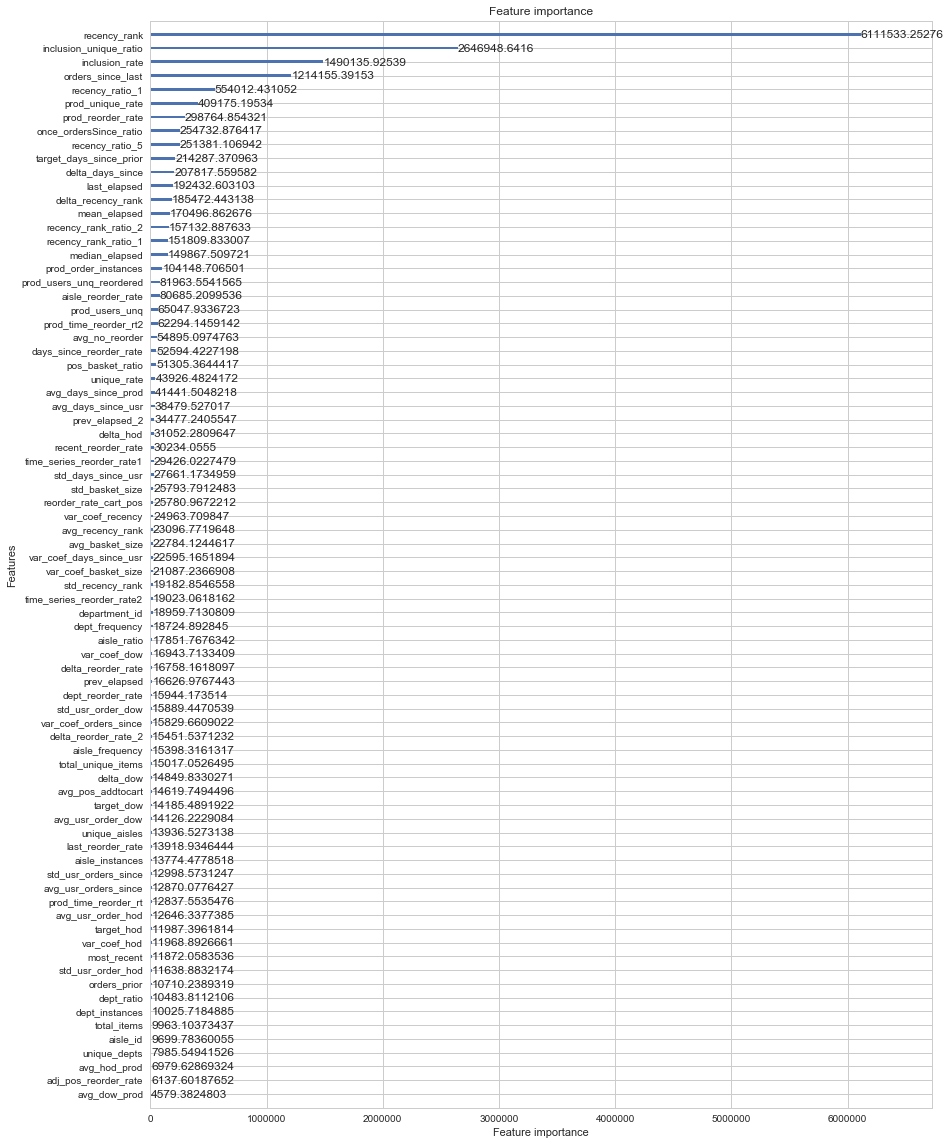

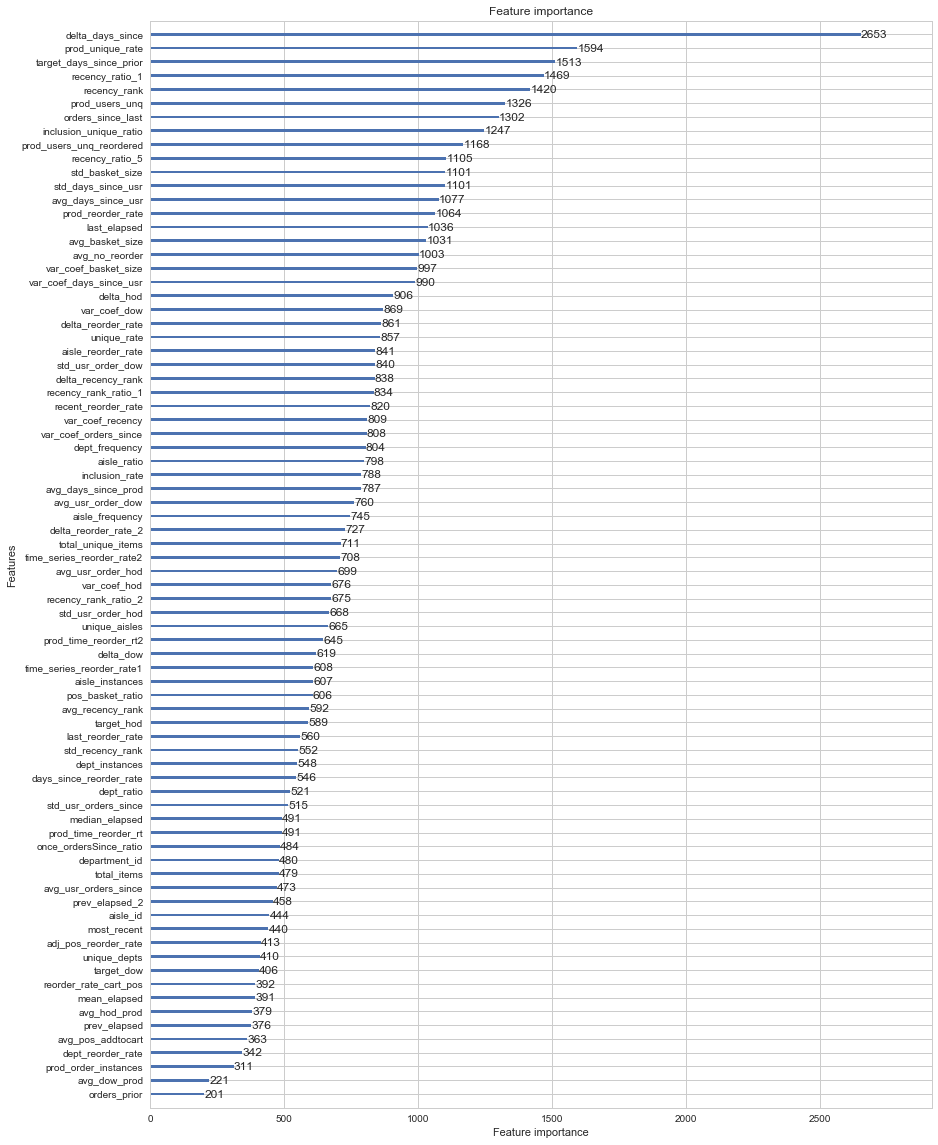

In [14]:
##### TRAINING SET

columns     = ['avg_days_since_prod', 'avg_pos_addtocart', 'prod_time_reorder_rt', 'prod_unique_rate', 
               'target_hod', 'target_dow', 'target_days_since_prior',  'total_unique_items',
               'inclusion_unique_ratio', 'unique_aisles', 'unique_depts', 'most_recent',
               'recency_ratio_1', 'std_usr_order_hod', 'avg_usr_orders_since', 'avg_recency_rank', 
               'dept_frequency', 'aisle_frequency', 'time_series_reorder_rate2', 'last_elapsed',
               'avg_basket_size', 'std_days_since_usr', 'avg_usr_order_hod', 'avg_dow_prod',
               'recent_reorder_rate', 'avg_no_reorder', 'aisle_instances', 'dept_instances',
               'prod_order_instances', 'inclusion_rate', 'unique_rate', 'aisle_ratio',
               'reorder_rate_cart_pos', 'orders_since_last', 'last_reorder_rate',  'recency_rank',
                'std_usr_orders_since', 'prod_users_unq',  'recency_ratio_5', 'recency_rank_ratio_2',
               'delta_days_since', 'delta_dow', 'delta_hod', 'pos_basket_ratio',  
               'delta_reorder_rate', 'dept_ratio', 'std_usr_order_dow', 'avg_days_since_usr',
                'aisle_id', 'once_ordersSince_ratio', 'orders_prior', 'total_items',
               'department_id', 'adj_pos_reorder_rate', 'std_basket_size', 'avg_hod_prod',
               'delta_recency_rank', 'recency_rank_ratio_1', 'std_recency_rank', 'var_coef_recency',
               'prod_reorder_rate', 'dept_reorder_rate', 'aisle_reorder_rate', 'avg_usr_order_dow',
               'days_since_reorder_rate', 'delta_reorder_rate_2', 'prev_elapsed_2', 'prev_elapsed',
               'prod_time_reorder_rt2', 'median_elapsed', 'mean_elapsed', 'time_series_reorder_rate1',
               'prod_users_unq_reordered', 'var_coef_dow', 'var_coef_basket_size', 'var_coef_orders_since',
               'var_coef_hod', 'var_coef_days_since_usr'
               ] # 78 features 
#               '0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18',
#               '19','20','21','22','23','24','25','26','27','28','29','30','31'
#             
#                 NOT USED:  'ordered_only_once', 'once_not_last_three', 'reordered_and_in_last',
#                 NOT USED:  'new_in_last', 'totaldepts','totalaisles', 'two_more_of_four', 
#                 NOT USED:  'both_last_two', 'all_last_three', 'all_last_four', 'three_more_of_four',
#                 NOT USED:  'in_most_recent', 'once_not_last', second_not_last, third_not_last_two
#                 NOT USED:  'user_id',  'label', ''order_id', 'cart_pos_reorder_rate',
#                 NOT USED:  'hod_reorder_rate', 'dow_reorder_rate', 'product_id'
#                 NOT USED:  'delta_reorder_rate_3', 'delta_reorder_rate_4', 'delta_reorder_rate_5',
#                 NOT USED:  'delta_reorder_rate_6', 'delta_reorder_rate_7', 'recency_ratio_2'
#                 NOT USED:  'recency_ratio_3', 'recency_ratio_4', 
#                 NOT USED:   


labels      = train_df['label'].values

insta_train = lgb.Dataset(train_df[columns],
                          label=labels)

                          #categorical_feature=['second_not_last',
                          #                     'third_not_last_two'
                          #                    ])
                                               #'once_not_last'
                                               # 'in_most_recent',
                                               #'reordered_and_in_last',
                                               #'aisle_id', 
                                               #'department_id'
                                               #'ordered_only_once'
                                               #'once_not_last_three',
                                               #'new_in_last'
                                               #'both_last__two_orders', 
                                               #'all_three_last_orders', 
                                               #'all_four_last_orders',
                                               #'two_more_of_four',
                                               #'three_more_of_four',

X_train, X_val, y_train, y_val = train_test_split(train_df[columns], 
                                                  labels, 
                                                  test_size=0.2, 
                                                  random_state=30)
            
valid_data  = insta_train.create_valid(X_val, label=y_val)


params      = {
    'task'                 : 'train',
    'boosting_type'        : 'gbdt',
    'objective'            : 'binary',
    'learning_rate'        : 0.002,
    'metric'               : {'auc'},
    'num_leaves'           : 70,
    'max_depth'            : 6,
    'feature_fraction'     : 0.6,
    'feature_fraction_seed': 17,
    'bagging_fraction'     : 0.9,
    'bagging_freq'         : 5
    #'lambda_l2'            :
    #'cat_smooth_ratio'     : 0.25
    #'min_data_in_leaf'     : 50
              }
ROUNDS      = 1000

bst = lgb.train(params, 
                insta_train, 
                ROUNDS, 
                valid_sets=valid_data, 
                early_stopping_rounds=10)
del X_train
del X_val
del y_train
del y_val

lgb.plot_importance(bst, figsize=(14,20), importance_type='gain')
lgb.plot_importance(bst, figsize=(14,20), importance_type='split');

In [15]:
lgb.cv(params, insta_train, nfold=5) # seed=0

{u'auc-mean': [0.81731785896046971,
  0.82337637742333691,
  0.82466084563309006,
  0.82591239578481501,
  0.8261755734463696,
  0.82628452814038111,
  0.82634798384567831,
  0.82653197384823862,
  0.82663329038428368,
  0.82693305443563625],
 u'auc-stdv': [0.00050810719656134819,
  0.00024454558496435022,
  0.00045589297609142687,
  0.00040029567106305468,
  0.00043219675526089683,
  0.00040731687389563702,
  0.00037651320229531611,
  0.00034832290126771468,
  0.00035291230763453833,
  0.0003318884804495016]}

In [3]:
#train_df.to_csv('test_df_LightGBM_v28.csv', index=False)
#bst.save_model('model_73_features_v165_with_valid_auc.txt')
#bst = lgb.Booster(model_file='model_64_features_v92_with_valid.txt')
train_df = pd.read_csv('../Instacart_Notebooks/test_df_LightGBM_v28.csv')
test_df = pd.read_csv('../Instacart_Notebooks/test_df_LightGBM_v30.csv')

train_df = train_df.replace(to_replace=[np.inf, -np.inf], value=np.nan).fillna(-1000)
test_df  = test_df.replace(to_replace=[np.inf, -np.inf], value=np.nan).fillna(-1000)

train_df.head()

,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,label,total_items,...,delta_recency_rank,recency_rank_ratio_1,recency_rank_ratio_2,var_coef_orders_since,var_coef_recency,last_elapsed,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed
0,1,196,2,10,20,1,1.523884,0.258285,1.0,59,...,-33.0,-1.333333,-0.392157,1.170384,-4.219179,30.0,0.0,14.0,19.5,18.250000
1,1,10258,3,11,20,3,1.523884,0.258285,1.0,59,...,-33.0,-1.333333,-0.392157,1.170384,-4.219179,30.0,0.0,14.0,20.0,18.714286
2,1,10326,4,15,28,5,1.523884,0.258285,0.0,59,...,-21.0,-2.666667,-6.666667,1.170384,-4.219179,-1.0,-1.0,-1.0,-1.0,-1.000000
3,1,12427,2,10,20,3,1.523884,0.258285,0.0,59,...,-33.0,-1.333333,-0.392157,1.170384,-4.219179,30.0,0.0,14.0,19.5,18.250000
4,1,13032,3,8,22,6,1.523884,0.258285,1.0,59,...,-5.0,-1.333333,-0.740741,1.170384,-4.219179,44.0,117.0,-1.0,117.0,117.000000


,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed,pred,p_none,usr_p_none,max_pred,xgb_pred,max_pred_xgb
0,3,248,3,19,9,3,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.026572,0.973428,0.000836,0.791926,0.312511,0.623035
1,3,1005,3,16,17,5,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.065134,0.934866,0.000836,0.791926,0.327140,0.623035
2,3,1819,1,16,11,3,2.103388,0.286826,88,9,...,19.0,-1.0,19.0,19.0,0.125677,0.874323,0.000836,0.791926,0.345154,0.623035
3,3,7503,3,16,21,6,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.035009,0.964991,0.000836,0.791926,0.314982,0.623035
4,3,8021,3,19,9,5,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.039362,0.960638,0.000836,0.791926,0.316962,0.623035


[0]	eval-auc:0.826255	train-auc:0.828173
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[10]	eval-auc:0.83308	train-auc:0.836106
[20]	eval-auc:0.83422	train-auc:0.838338
[30]	eval-auc:0.835297	train-auc:0.840568
[40]	eval-auc:0.836081	train-auc:0.84261
[50]	eval-auc:0.836636	train-auc:0.844359
[60]	eval-auc:0.837138	train-auc:0.846037
[70]	eval-auc:0.83762	train-auc:0.847551
[80]	eval-auc:0.838086	train-auc:0.84898
[90]	eval-auc:0.838463	train-auc:0.850422
[100]	eval-auc:0.838857	train-auc:0.851724
[110]	eval-auc:0.839131	train-auc:0.85296
[120]	eval-auc:0.839438	train-auc:0.854206
[130]	eval-auc:0.839702	train-auc:0.855345
[140]	eval-auc:0.839993	train-auc:0.85656
[149]	eval-auc:0.840209	train-auc:0.857562
150


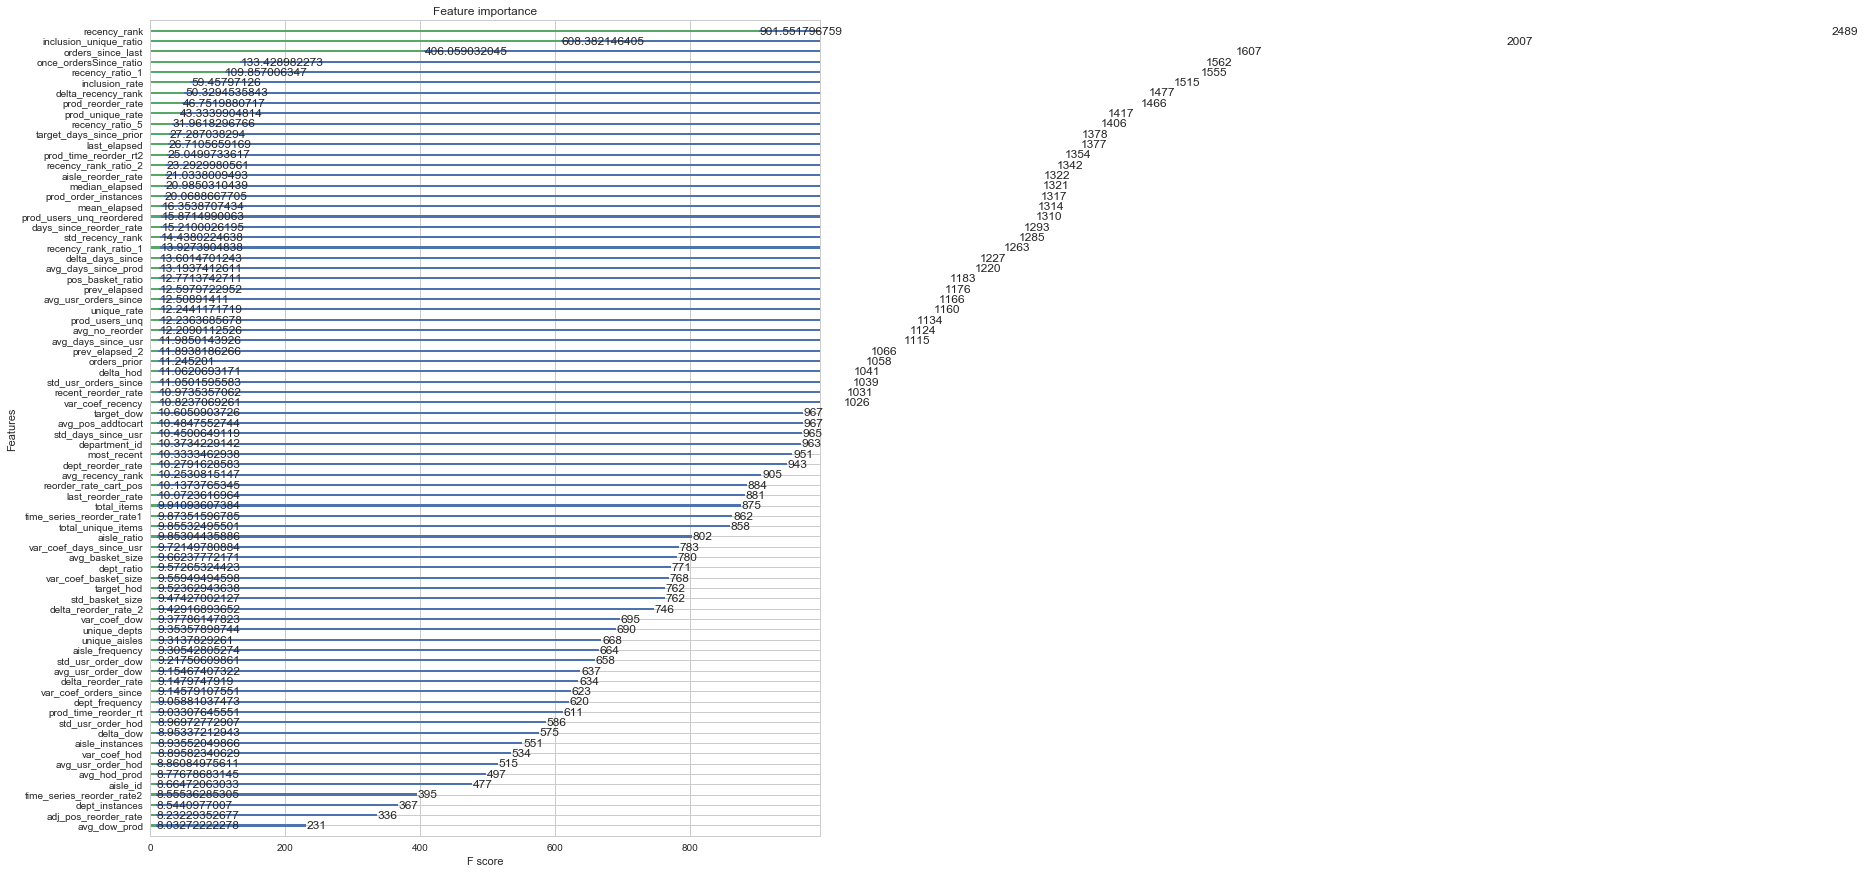

In [ ]:
# XGBoost

columns     = ['avg_days_since_prod', 'avg_pos_addtocart', 'prod_time_reorder_rt', 'prod_unique_rate', 
               'target_hod', 'target_dow', 'target_days_since_prior',  'total_unique_items',
               'inclusion_unique_ratio', 'unique_aisles', 'unique_depts', 'most_recent',
               'recency_ratio_1', 'std_usr_order_hod', 'avg_usr_orders_since', 'avg_recency_rank', 
               'dept_frequency', 'aisle_frequency', 'time_series_reorder_rate2', 'last_elapsed',
               'avg_basket_size', 'std_days_since_usr', 'avg_usr_order_hod', 'avg_dow_prod',
               'recent_reorder_rate', 'avg_no_reorder', 'aisle_instances', 'dept_instances',
               'prod_order_instances', 'inclusion_rate', 'unique_rate', 'aisle_ratio',
               'reorder_rate_cart_pos', 'orders_since_last', 'last_reorder_rate',  'recency_rank',
                'std_usr_orders_since', 'prod_users_unq',  'recency_ratio_5', 'recency_rank_ratio_2',
               'delta_days_since', 'delta_dow', 'delta_hod', 'pos_basket_ratio',  
               'delta_reorder_rate', 'dept_ratio', 'std_usr_order_dow', 'avg_days_since_usr',
                'aisle_id', 'once_ordersSince_ratio', 'orders_prior', 'total_items',
               'department_id', 'adj_pos_reorder_rate', 'std_basket_size', 'avg_hod_prod',
               'delta_recency_rank', 'recency_rank_ratio_1', 'std_recency_rank', 'var_coef_recency',
               'prod_reorder_rate', 'dept_reorder_rate', 'aisle_reorder_rate', 'avg_usr_order_dow',
               'days_since_reorder_rate', 'delta_reorder_rate_2', 'prev_elapsed_2', 'prev_elapsed',
               'prod_time_reorder_rt2', 'median_elapsed', 'mean_elapsed', 'time_series_reorder_rate1',
               'prod_users_unq_reordered', 'var_coef_dow', 'var_coef_basket_size', 'var_coef_orders_since',
               'var_coef_hod', 'var_coef_days_since_usr'
               ] # 78 features 

labels      = train_df['label'].values
X_train, X_val, y_train, y_val = train_test_split(train_df[columns], 
                                                  labels, 
                                                  test_size=0.2, 
                                                  random_state=21)

d_train                        = xgb.DMatrix(X_train, y_train)
d_val                          = xgb.DMatrix(X_val, y_val)
xgb_params                     = {
    "objective"        : "binary:logistic",
    "eval_metric"      : "auc",
    "eta"              : 0.11,
    "max_depth"        : 10,
    "min_child_weight" : 20,
    "subsample"        : 0.65,
    "colsample_bytree" : 0.70,
    "alpha"            : 2e-05
    #"lambda"           : 10
}

watchlist                      = [(d_val, 'eval'), (d_train, 'train')]
bstxgb                         = xgb.train(params=xgb_params, 
                                           dtrain=d_train, 
                                           num_boost_round=150, 
                                           evals=watchlist,
                                           early_stopping_rounds=10,
                                           verbose_eval=10)

del X_train
del X_val
del y_train
del y_val
fig, ax = plt.subplots(1,1,figsize=[12,15])
print bstxgb.best_ntree_limit
xgb.plot_importance(bstxgb, ax=ax, importance_type='weight')
xgb.plot_importance(bstxgb, ax=ax, importance_type='gain');

In [14]:
#xgb.cv(xgb_params, d_train, nfold=5,
#       metrics={'auc'}, seed = 1)
test_df.head()

,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed,pred,p_none,usr_p_none,max_pred,xgb_pred,max_pred_xgb
0,3,248,3,19,9,3,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.026572,0.973428,0.000836,0.791926,0.312511,0.623035
1,3,1005,3,16,17,5,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.065134,0.934866,0.000836,0.791926,0.327140,0.623035
2,3,1819,1,16,11,3,2.103388,0.286826,88,9,...,19.0,-1.0,19.0,19.0,0.125677,0.874323,0.000836,0.791926,0.345154,0.623035
3,3,7503,3,16,21,6,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.035009,0.964991,0.000836,0.791926,0.314982,0.623035
4,3,8021,3,19,9,5,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,0.039362,0.960638,0.000836,0.791926,0.316962,0.623035


In [ ]:
from catboost import CatBoostClassifier

# specify the training parameters 
model = CatBoostClassifier(iterations=2, 
                           depth=8, 
                           learning_rate=.1, 
                           loss_function='Logloss', 
                           l2_leaf_reg=1,
                           verbose=True)
#cat_features_ids = np.where(train_df.apply(pd.Series.nunique) < 100000)[0].tolist()

#train the model
model.fit(train_df[columns], labels, verbose=True) #cat_features=cat_features_ids

# make the prediction using the resulting model
preds_class = model.predict(test_df[columns])
preds_proba = model.predict_proba(test_df[columns])
print("class = ", preds_class)
print("proba = ", preds_proba)


predictions = []

for i in range(5):
    model.fit(train_df[columns], labels)#cat_features=cat_features_ids
    predictions.append(model.predict_proba(test_df[columns])[:,1])

test_df['cat_pred'] = np.mean(predictions, axis=0)
test_df.head()

In [16]:
# TEST SET

try:
    test_df = test_df.drop(['max_pred', 'p_none', 'usr_p_none', 'pred'], axis=1)
except:
    pass

print 'lightGBM & XGBoost formulating predictions...'
preds                   = bst.predict(test_df[columns], num_iteration=bst.best_iteration)
test_df['pred']         = preds

test_df['p_none']       = (1 - test_df['pred'])
user_nones              = pd.DataFrame(test_df.groupby(['user_id']).apply(lambda x: x['p_none'].product())).reset_index()
test_df                 = test_df.merge(user_nones,
                                        on='user_id',
                                        how='left')
test_df.rename(columns  ={0 : 'usr_p_none'}, inplace=True)


maxpreds                = pd.DataFrame(test_df.groupby(['user_id'])['pred'].max()
                                      ).reset_index()
maxpreds.rename(columns ={'pred' : 'max_pred'}, inplace=True)
test_df                 = test_df.merge(maxpreds,
                                        on='user_id',
                                        how='left')

#d_test = xgb.DMatrix(test_df[columns])
#test_df['xgb_pred']     = bstxgb.predict(d_test, ntree_limit=bstxgb.best_ntree_limit)

#max_xgb                 = pd.DataFrame(test_df.groupby(['user_id'])['xgb_pred'].max()
#                                      ).reset_index()
#max_xgb.rename(columns  ={'xgb_pred' : 'max_pred_xgb'}, inplace=True)
#test_df                 = test_df.merge(max_xgb,
#                                        on='user_id',
#                                        how='left')

test_df.head(20)

lightGBM & XGBoost formulating predictions...


,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,last_elapsed,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed,usr_threshold,pred,p_none,usr_p_none,max_pred
0,3,248,3,19,9,3,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,-1.000000,0.337655,0.026616,0.973384,0.000817,0.792207
1,3,1005,3,16,17,5,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,-1.000000,0.337655,0.065719,0.934281,0.000817,0.792207
2,3,1819,1,16,11,3,2.103388,0.286826,88,9,...,7.0,19.0,-1.0,19.0,19.000000,0.337655,0.123700,0.876300,0.000817,0.792207
3,3,7503,3,16,21,6,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,-1.000000,0.337655,0.034597,0.965403,0.000817,0.792207
4,3,8021,3,19,9,5,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,-1.000000,0.337655,0.038122,0.961878,0.000817,0.792207
5,3,9387,1,16,12,4,2.103388,0.286826,88,9,...,7.0,7.0,12.0,12.0,23.000000,0.337655,0.106256,0.893744,0.000817,0.792207
6,3,12845,2,18,20,2,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,-1.000000,0.337655,0.031664,0.968336,0.000817,0.792207
7,3,14992,0,16,7,7,2.103388,0.286826,88,9,...,7.0,-1.0,-1.0,-1.0,-1.000000,0.337655,0.083076,0.916924,0.000817,0.792207
8,3,15143,1,14,0,3,2.103388,0.286826,88,9,...,-1.0,-1.0,-1.0,-1.0,-1.000000,0.337655,0.019967,0.980033,0.000817,0.792207
9,3,16797,0,15,7,4,2.103388,0.286826,88,9,...,14.0,76.0,-1.0,76.0,76.000000,0.337655,0.152681,0.847319,0.000817,0.792207


In [15]:
#test_df.to_csv('test_df_LightGBM_v30.csv', index=False)
#test_df['geometric_mean_prob'] = np.exp(np.mean(np.log(test_df[['pred']]), np.log(test_df[['pred']])))
#test_df.head()
#test_df[test_df['pred'] >= .9]

,user_id,product_id,avg_dow_prod,avg_hod_prod,avg_days_since_prod,avg_pos_addtocart,std_basket_size,var_coef_basket_size,total_items,unique_depts,...,var_coef_recency,last_elapsed,prev_elapsed,prev_elapsed_2,median_elapsed,mean_elapsed,pred,p_none,usr_p_none,max_pred
5264,233,24852,4,11,9,3,7.672027,0.401257,478,12,...,-1.215130,19.0,7.0,7.0,7.0,8.105263,0.902490,0.097510,2.377977e-14,0.902490
8055,318,14233,4,13,14,1,0.000000,0.000000,7,1,...,-1.000000,8.0,20.0,17.0,17.0,15.400000,0.900175,0.099825,9.982515e-02,0.900175
11024,458,21709,3,12,15,3,3.756313,0.328677,160,9,...,-4.345148,12.0,15.0,11.0,14.0,15.666667,0.915467,0.084533,9.625780e-10,0.919424
11032,458,35221,3,12,15,3,3.756313,0.328677,160,9,...,-4.345148,12.0,15.0,11.0,14.0,15.666667,0.912084,0.087916,9.625780e-10,0.919424
11040,458,44632,3,12,15,3,3.756313,0.328677,160,9,...,-4.345148,12.0,15.0,11.0,14.0,15.666667,0.919424,0.080576,9.625780e-10,0.919424
15019,652,20598,3,15,3,2,2.490205,0.475995,497,12,...,-1.182215,6.0,2.0,2.0,3.0,4.048780,0.912763,0.087237,5.209104e-06,0.912763
18264,798,24838,4,13,12,2,1.164500,0.208567,67,5,...,-2.525731,7.0,6.0,11.0,9.0,12.300000,0.908177,0.091823,1.333736e-04,0.908177
18276,798,43295,4,13,12,3,1.164500,0.208567,67,5,...,-2.525731,7.0,6.0,11.0,9.0,12.300000,0.903620,0.096380,1.333736e-04,0.908177
24423,1057,4210,2,17,20,3,16.010413,0.578690,83,13,...,4.418370,30.0,10.0,-1.0,10.0,10.000000,0.918596,0.081404,1.502863e-37,0.935087
24450,1057,24852,2,17,20,4,16.010413,0.578690,83,13,...,4.418370,30.0,10.0,-1.0,10.0,10.000000,0.935087,0.064913,1.502863e-37,0.935087


In [21]:

thresholds = {}
add_none   = []
margin_of_error = 0

try:
    test_df = test_df.drop(['usr_threshold'], axis=1)
except:
    pass

class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        #print '\nexpectations', np.array(expectations[::-1])
        
        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)
        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]
        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        #try:
        #    if ( (predNone == False) & ( (max_f1 - expectations[(ix_max[0],(ix_max[1]-1))] ) <= .01) ):
        #        max_f1 = expectations[(ix_max[0],(ix_max[1]-1))]
        #        best_k = ix_max[1]-1
        #        margin_of_error+=1
        #except:
        #    pass
        
        #print '\nexpectations:', expectations
        #print '\nexpectations[ix_max]:', expectations[ix_max]
        #print '\nbest_k:', best_k
        #print '\nmax_f1:', max_f1, '\n'
    
        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)


def print_best_prediction(P, pNone=None):
    #print 'Maximize F1-Expectation'
    #print '=' * 23
    P = np.sort(P)[::-1]
    n = P.shape[0]
    L = ['L{}'.format(i + 1) for i in range(n)]

    if pNone is None:
        #print 'Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)\n'
        pNone = (1.0 - P).prod()

    PL = ['p({}|x)={}'.format(l, p) for l, p in zip(L, P)]
    #print 'Posteriors: {} (n={})'.format(PL, n)
    #print 'p(None|x)={}'.format(pNone)

    opt = F1Optimizer.maximize_expectation(P, pNone)
    best_prediction = ['None'] if opt[1] else []
    best_prediction += (L[:opt[0]])
    f1_max = opt[2]

    #print '\n\nPrediction {} yields best E[F1] of {}\n'.format(best_prediction, f1_max)
    #print '\n opt:', opt
    #print '\n PL:',  PL, '\n'
    #print '\n  L:', L, '\n'
    #print '\n  n:', n, '\n'
    #print '\n\nP:', P, '\n'
    
    if   ( ('None' in best_prediction) & (len(best_prediction) == 1) ):
        thresholds[user] = 'None'
    elif ( ('None' in best_prediction) & (len(best_prediction)  > 1) ): 
        add_none.append(user)
        thresholds[user] = P[len(best_prediction)-2]
    else:
        thresholds[user] = P[len(best_prediction)-1]
    
    #print '\nusr_threshold:', P[len(best_prediction)-1]

if __name__ == '__main__':
    count = 0
    print 'Processing F1 score thresholding --Approx. 35min-- ...\n'
    x = test_df[test_df['pred'] > .01]
    for user in np.unique(test_df.user_id):
        print_best_prediction(x[x['user_id'] == user]['pred'].values)
        count+=1
        if count % 10000 == 0:
            print count, 'completed...'
del x
thresholds = pd.DataFrame.from_dict(thresholds, orient='index').reset_index()
thresholds.rename(columns={'index' : 'user_id', 0 :'usr_threshold'}, inplace=True)
test_df                 = test_df.merge(thresholds,
                                        on='user_id',
                                        how='left')
print 'I\'ll see you next time...'

Processing F1 score thresholding --Approx. 35min-- ...

10000 completed...
20000 completed...
30000 completed...
40000 completed...
50000 completed...
60000 completed...
70000 completed...
I'll see you next time...


In [22]:
import random
e = dict()

for row in test_df.itertuples():  
    if row.usr_threshold    == 'None':
        e[row.order_id]      = 'None'
    elif row.pred       >= row.usr_threshold:
        try:
            e[row.order_id] += ' ' + str(row.product_id)
        except:
            e[row.order_id]  = str(row.product_id)
            
    if row.Index % 1000000  == 0:
        print row.Index, 'completed [round 1]...'


print 'Processing None-Group data -- 5min -- ...'
test_set = orders[orders['eval_set'] == 'test']
for order in test_set.order_id:
    if order not in e:
        e[order] = 'None'

high_risk_list1 = np.unique(test_df[test_df['user_id'].isin(add_none)][['order_id']].values)
v               = pd.DataFrame(test_df[test_df['last_reorder_rate'] == 0].groupby('user_id').mean()
                              ).reset_index()  
high_risk_list2 = v['order_id'].values
high_risk_list3 = np.unique(test_df[test_df['max_pred'] < .25][['order_id']]
                           )
none_wide_margin_usrs   = np.unique(test_df[(test_df['usr_threshold'] != 'None') & (test_df['usr_p_none'] > (test_df['max_pred'] + .09))]['order_id'])
none_low_threshold_usrs = np.unique(test_df[(test_df['usr_threshold'] != 'None') & (test_df['usr_p_none'] > (test_df['max_pred'] + .03)) & (test_df['usr_threshold'] < .15)]['order_id']) 

count_highrisk = 0
for order in e:
    if ( (order in high_risk_list1) & ('None' not in e[order]) ): # | (order in high_risk_list2) | (order in high_risk_list3)
        e[order] += ' None'
        count_highrisk+=1
        
for order in e:
    if ( ((order not in high_risk_list1) & ('None' not in e[order])) & ((order in high_risk_list2) | (order in high_risk_list3)) ): # | (order in high_risk_list2) | (order in high_risk_list3)
#        r = random.randint(0,1)
#        if r == 1:
        e[order] += ' None'
        count_highrisk+=1

for order in none_wide_margin_usrs:
        e[order] = 'None'
for order in none_low_threshold_usrs:
        e[order] = 'None'

        
print count_highrisk, 'orders identified as high-risk that do not already contain None'        
        
submission = pd.DataFrame.from_dict(e, orient='index')
submission.reset_index(inplace=True)
submission.columns = ['order_id', 'products']


print 'submission order-list length:', len(submission)
submission.to_csv('submission_lightGBM_v225.csv', index=False)
#submission.to_csv('submission_xgboost_v195.csv', index=False)

0 completed [round 1]...
1000000 completed [round 1]...
2000000 completed [round 1]...
3000000 completed [round 1]...
4000000 completed [round 1]...
Processing None-Group data -- 5min -- ...
10178 orders identified as high-risk that do not already contain None
submission order-list length: 75000


In [17]:
#test_df[test_df['pred'] <= .01]

In [ ]:
#print 'max_pred < 25% Nones: ', len(high_risk_list3)
#print 'reorder_rate == 0 Nones: ', len(high_risk_list2)

print 'F1 optimized Nones: ', len(high_risk_list1)
#print 'overlap of max_pred / F1 high-risk groups:', len([x for x in high_risk_list1 if (x in high_risk_list3) ])

#print 'overlap of reorder_rate / F1 high-risk groups:', len([x for x in high_risk_list2 if (x in high_risk_list3) ])
#print len(none_wide_margin_usrs) + len(none_low_threshold_usrs) # 1,081



### ---- Notes -----

v75 former best - Using F1 optimized thresholds. 8,104 None, 619k products, 0.3953992

v76 NONONO - submission_lightGBM_v76  (NONE HANDLING FOR 
last_reorder_rate == 0 and low max_pred. < .40), 0.3949089

v77 former best - - submission_lightGBM_v77 (NONE HANDLING FOR 
last_reorder_rate == 0 and low max_pred. < .25) 11,680 None, 623k products, 0.3956202

v78 NONONONO - Using F1 optimized thresholds, None handling only for add_none and last_reorder_rate == 0 9,898 None, 621k products, 0.3955026

v79 NONONONO - Using F1 optimized thresholds, None handling only for add_none and max_pred < 0.30 13,157 None, 624k products, 0.3955943

v80 NONONONO - Using F1 optimized thresholds, None handling only for add_none and max_pred < 0.21  9,246 None, 620.5k products,  0.3955305

v81 NONONONO - Using F1 optimized thresholds, None handling for add_none and max_pred < 0.21 & for last_reorder_rate == 0 10,765 None, 622k products, 0.3956006

v82 former best - Using F1 optimized thresholds, None handling for add_none/none_wide_margin_usrs(.10)/none_low_threshold_usrs(+.03, <.15) and max_pred < 0.25 & for last_reorder_rate == 0 11,929 None, 622.4k products, 0.3958616

v83 NONONO - Using F1 optimized thresholds, None handling for add_none/none_wide_margin_usrs(.09)/none_low_threshold_usrs(+.02, <.15) and max_pred < 0.3 & for last_reorder_rate == 0 14,509 None, 624.6k products, 0.3958455

v84 former best - Using F1 optimized thresholds, None handling for add_none/none_wide_margin_usrs(.09)/none_low_threshold_usrs(+.01, <.15) and max_pred < 0.25 & for last_reorder_rate == 0 11,929 None, 621.7k products, 0.3959093

v85 - Using F1 optimized thresholds, None handling for add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs(<.15) and max_pred < 0.25 & for last_reorder_rate == 0 11,929 None, 621.1k products, 

v86 - Using F1 optimized thresholds, None handling for add_none/none_wide_margin_usrs(.02)/none_low_threshold_usrs(<.19) and max_pred < 0.25 & for last_reorder_rate == 0 11,929 None, 620.5k products, 

v87 - THREE new features, 64 total, Using F1 optimized thresholds, None handling for add_none/none_wide_margin_usrs(.02)/none_low_threshold_usrs(<.19) and max_pred < 0.25 & for last_reorder_rate == 0 12,081 None, 622k products, 

v88 - THREE new features, 64 total 
    Using F1 optimized thresholds, 
    None handling for 
        add_none/none_wide_margin_usrs(.09)/none_low_threshold_usrs( <.15) and 
        max_pred < 0.25 & for last_reorder_rate == 0 12,081 None, 623k products,

v90 NONONONO - THREE new features, 64 total, 
      NEW recency_rank (subtracts 'orders_since_last')
      0.347883 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.02)/none_low_threshold_usrs( <.19) and 
          max_pred < 0.25 & for last_reorder_rate == 0 12,130 None, 626k products, 0.3958686

v91 former best - THREE new features, 64 total, 
      NEW recency_rank (subtracts 'orders_since_last')
      0.347883 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 12,130 None, 626.6k products, 0.3959307

v92  NONONONO - THREE new features, 64 total
      NEW recency_rank (subtracts 'orders_since_last')
      0.347883 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.10) and 
          max_pred < 0.30 & for last_reorder_rate == 0 
          14,732 None, 630k products, 0.3957194

v93 NONONONO - THREE new features, 64 total
      NEW recency_rank (subtracts 'orders_since_last')
      0.347883 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.02)/none_low_threshold_usrs( <.10) and 
          max_pred < 0.27 & for last_reorder_rate == 0 
           13,027 None, 627.5k products, 0.3958097

v94 NONONONO - THREE new features, 64 total
      NEW recency_rank (subtracts 'orders_since_last')
      0.347883 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.10) and 
          max_pred < 0.23 & for last_reorder_rate == 0 
           11,383 None, 626.6k products, 0.3959094

v95 - THREE new features, 64 total
      NEW recency_rank (subtracts 'orders_since_last')
      0.347883 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.09)/none_low_threshold_usrs( <.16) and 
          max_pred < 0.23 & for last_reorder_rate == 0 
           11,383 None, 626k products, 

v96 - 64 total features
      trained with VALIDATION set -- ERROR IN IMPLEMENTATION
      0.347865 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.23 & for last_reorder_rate == 0 
           11,517 None, 630k products, 0.3954939
      NOT with gridsearch-optimized parameters
      
v97 - 64 total features
      trained with VALIDATION set (20%), 175L, max-depth: 9
      0.347823 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 
            None, k products, 
      NOT with gridsearch-optimized parameters

v98 - 64 total features
      trained with VALIDATION set (20%), 175L, max-depth: 9
      0.347823 logloss 
      Using F1 optimized thresholds for ONLY best_k <= 10,
      Using variable basket-sized thresholding if above_threshold > 10
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 
          12,198 None, 578.6k products, 0.3920367
      NOT with gridsearch-optimized parameters
      
v99 NONONO - 64 total features
      trained with VALIDATION set (20%), 175L, max-depth: 9
      0.347823 logloss 
      Using F1 optimized thresholds
                seeks to reduce over-fitting by reducing basket-sizes for orders where the expected F1 score is substantially similar for the (best_k) vs. (best_k - 1)
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 
          12,198  None, 575.6k products, 0.3934962
      NOT with gridsearch-optimized parameters


v100 - XGBoost
      0.210015 logloss 
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 
            None, k products, 

v101 NONONONO - Blended XGBoost & LightGBM
      Using F1 optimized thresholds,  175L, max-depth: 9
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 
           12,258 None, 624.1k products, 0.3940178

(see big computer version of this notebook v27

v105 NONONO - LightGBM
      175L, max-depth: 10, metric: logloss
      0.347734 logloss
      Reduced feature-set (redundant recency binaries)
      includes STD / var_coef recency rank, & 
          avg_days_since_usr/avg_usr_order_hod/avg_usr_order_dow
      fewer categorical features (aisles/dpts are now numeric)
      fillna(0) (NaN's for days_since_prod for first order, etc)
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 
          12,095  None, 628.4k products, 0.3956759

v106 former best - LightGBM
      same as v105 but w/ prod/dept/aisle reorder rates
      200L, max-depth: 10, metric: AUC
      0.829844 AUC
      fillna(0) (NaN's for days_since_prod for first order, etc)
      Using F1 optimized thresholds
      None handling for      
          add_none/none_wide_margin_usrs(.05)/none_low_threshold_usrs( <.15) and 
          max_pred < 0.25 & for last_reorder_rate == 0 
           11,912 None, 631.5k products, 0.3982912
           
v107 former best - LightGBM
      same as v106 except 150L
      0.829350 AUC
      12,001 None, 630.7k products, 0.3983713

v108v1 - XGBoost
      same as v107 except with XGBoost
      max-depth: 10, metric: AUC
      0.859056 AUC
      11,944  None, 629.6k products, 0.3967734

v109 former best- LightGBM
      same as v106 except 150L, rounded vars round avg_dow_prod, avg_hod_prod 
                                      avg_days_since_prod, avg_pos_addtocart
                                      with mistake - no test group
      0.829481 AUC
      11,859 None, 629.6k products, 0.3986436

v110 - LightGBM
      same as v109 except 125L, rounded vars round avg_dow_prod, avg_hod_prod 
                                      avg_days_since_prod, avg_pos_addtocart
      0.829069 AUC
      11,824 None, 628.8k products, 0.3989267

v111 former best - LightGBM
      same as v109 except 150L, rounded vars round avg_dow_prod, avg_hod_prod 
                                      avg_days_since_prod, avg_pos_addtocart
       AUC
      11,913 None, 629.4k products, 0.3989608

v112 NONONONO - LightGBM
      same as v111 except all new rounded variables
      0.829353 AUC
      11,892 None, 629.4k products, 0.3985831


v115 former best - LightGBM
      same as v111 except with 4 new reorder rates (cart_pos, hod/dow/days_since)
           AND new calculation of delta_recency_rank & recency_rank_ratio,
           AND rounded variables avg_days_since_usr, avg_order_dow, avg_order_hod
       0.829428 AUC
      11,956 None, 630.1k products, 0.3989631
      
v116 former best - LightGBM
      same as v111 except with 4 new reorder rates (cart_pos, hod/dow/days_since)
           AND new calculation of delta_recency_rank & recency_rank_ratio,
           AND rounded variables avg_days_since_usr, avg_order_dow, avg_order_hod
       0.829425 AUC
       12,003 None, 631.3k products, 0.3991039

v117 NONONO - LightGBM
      same as v116 w/ None added to everything  < 30 max_pred (vs 25% standard)
       0.829425 AUC
       14,425 None, 633.8k products, 0.3989646

v118 NONONO - LightGBM
      same as v116 w/ None added to everything  < 20 max_pred (vs 25% standard)
       0.829425 AUC
       10,646 None, 630k products, .3990509

v120  - LightGBM
      same as v116 except w/ time_series_reorder_rates (dept-dow-hod & aisle-dow-hod reorder 
          rts) AND related deltas 
          AND removed second-not-last, third-not-last-two, cart_pos_reorder_rate, 
                   dow_reorder_rate, hod_reorder_rate
       0.829334 AUC
       11,957 None, 630.5k products, 

v122 NONONONO  - LightGBM
      same as v120 except w/ product_hod reorder rate
       0.829403 AUC
       11,972 None, 630.7k products, 0.3985575


v130 NONONONO - LightGBM
      same as v120 except w/ 'product_id', 'prod_unique_rate', 'prod_users_unq_reordered',
               'prod_users_unq', and elapsed variables
               NEW params - -12 max-depth, .6 fraction, .05 learning-rate
       0.830682 AUC
       11,652 None, 648.4k products, 0.3984994
       
v131 former best - LightGBM
      same as v130 except w/ 
               OLD PARAMS
       0.830448 AUC
       12,007 None, 627.8k products, 0.4005603

v132 NEW BEST - LightGBM
      same as v131 except w/ 
               OLD PARAMS, 150 rounds, no delta_reorder_rate_6/7, or product_id
       0.830409 AUC
       12,018 None, 627.1k products, 0.4010320

v133 NONONONONO - LightGBM
      same as v132 except w/ 
               OLD PARAMS, 300 rounds
           AND rounded variables avg_days_since_usr, avg_order_dow, avg_order_hod

       0.830391 AUC
       11,936 None, 626k products, 0.4004631

v134  - LightGBM
       same as v133 except w/ Less None-handling ONLY F1 optimized None additions

       0.830391 AUC
       8,139 None, 622.5k products, 

v135  - LightGBM
       same as v133 except w/ random inclusion of None for high-risk-2/3
       0.830391 AUC
       10,062 None, 624.4k products, 

v140 NONONONO - LightGBM
          REMOVED 'avg_dow_prod', 'avg_hod_prod', 'orders_prior', 'most_recent',
          'total_items', 
          ADDED 2nd, 3rd, 4th recency_ratios, recency_rank_ratio_1/2 (4 variables)
        0.830428 AUC
        8,067 None, 620.6k products, 0.4006334

v141  - LightGBM
       same as v135 except w/ random inclusion of None for high-risk-2/3
          REMOVED 'avg_dow_prod', 'avg_hod_prod', 'orders_prior', 'most_recent',
          'total_items', 
          ADDED 2nd, 3rd, 4th recency_ratios, recency_rank_ratio_1/2 (4 variables)
        0.830428 AUC
        9,994 None, 622.5k products, 0.4006713

v142  - LightGBM
          REMOVED  'most_recent'
          ADDED 2nd, 3rd, 4th recency_ratios, recency_rank_ratio_1/2 (4 variables)
        0.830465 AUC
        None, k products, 

v145  - LightGBM
        2000 rounds
          ADDED 2nd, 3rd, 4th recency_ratios, recency_rank_ratio_1/2 (4 variables)
        0.830461 AUC
        12,120 None, 605.4k products,
        
v150  - LightGBM
        150 rounds
         ADDED 5th recency_ratios, revised recency_rank_ratio_2 
         AUC
        11,885 None, 625.9k products, 0.4005031

v155  - LightGBM
        150 rounds, .8 feature sample, .4 validation size
        0.83064 AUC
        11,954 None, 624.7k products, 0.4003404

v160  - LightGBM
        150 rounds, .75 feature sample, .4 validation size
          REMOVED var_coef's (training leakage?) except for recency, 73 features
        0.830511 AUC
        11,957 None, 626.1k products, 0.4008111


v165  - LightGBM
        150 rounds, .9 feature sample, .4 validation size
         REMOVED var_coef's
        0.830532 AUC
         None, k products,

v170  - LightGBM & XGBoost - no extra None handling (ONLY F1 optimized)
        REMOVED var_coef's
        same as v165 but ensemble method
         0.830532 AUC (LightGBM)
         0.833029 AUC (XGBoost)
         None, k products, 

v175  - XGBoost - no extra None handling (ONLY F1 optimized)
        REMOVED var_coef's
        same as v165 but ONLY XGBoost
        using validation set, cv caused crash, so no cv
         0.856605 AUC (XGBoost)
         8,290 None, 616k products, 

v180  - XGBoost - YES extra None handling
        REMOVED var_coef's
        using validation set, cv caused crash, so no cv
         0.856605 AUC (XGBoost)
         11,949 None, 619k products, 
          
v185  - XGBoost - YES extra None handling
        150 rounds, .7 feature sample, .3 validation size
        fillna(-1), > .01 preds, 78 features
        0.856673 AUC
        12,010 None, 624k products,

v190  NONONONO  - LightGBM - YES extra None handling
        150 rounds, .7 feature sample, .3 validation size
        fillna(-1), > .01 preds, 78 features
        0.830652 AUC
        11,960 None None, 623k products, 0.4009704

v195 NONONONO - LightGBM - YES extra None handling
        750 rounds, .6 feature sample, .2 validation size
        max-depth 6, num_leaves 85, bagging_fraction .9, learning rate = .05
        fillna(-1000), > .02 preds, 78 features
        0.8272019 AUC
        12,152 None None, 618k products, 0.4008510

v200  - LightGBM - YES extra None handling
        750 rounds, .6 feature sample, .2 validation size
        max-depth 6, num_leaves 85, bagging_fraction .9, learning rate = .05
        fillna(-1000), > .04 preds, 78 features
        0.8272019 AUC
        12,814 None None, 593.5k products, 0.4009296


v205  - LightGBM - YES extra None handling
        150 rounds, .6 feature sample, .2 validation size
        fillna(-1000), > .06 preds, 78 features
        0.830732 AUC
        13,686 None None, 564.5k products, 0.4007056


v210  - LightGBM - YES extra None handling
        1000 rounds, .6 feature sample, .2 validation size
        max-depth 6, num_leaves 70, bagging_fraction .9, learning rate = .05
        fillna(-1000), > .06 preds, 78 features
         0.827201 AUC
        13,693 None None, 566.6k products,


v215  - LightGBM - YES extra None handling
        1000 rounds, .6 feature sample, .2 validation size
        max-depth 6, num_leaves 70, bagging_fraction .9, learning rate = .05
        fillna(-1000), > .06 preds, 78 features
         0.8269330 AUC
        13,685 None None, 566.9k products,

v220  - LightGBM - YES extra None handling
        1000 rounds, .6 feature sample, .2 validation size
        max-depth 6, num_leaves 70, bagging_fraction .9, learning rate = .035
        fillna(-1000), > .04 preds, 78 features
         0.8269330 AUC
        12,739 None None, 593.k products,

v225  - LightGBM - YES extra None handling
        1000 rounds, .6 feature sample, .2 validation size
        max-depth 6, num_leaves 70, bagging_fraction .9, learning rate = .002
        fillna(-1000), > .01 preds, 78 features
         0.8269330 AUC
         None None, k products,


In [ ]:
#min-max scaling -- potential candidates...

# 
from sklearn import preprocessing

days_since_binArray = # np.array of feature instances
min_max_scaler = preprocessing.MinMaxScaler()

X_train_mninmax = min_max_scaler.fit_transform(days_since_binArray)

In [38]:
# Binning based on days_since_prior_order greater_than_29

#  3.20%, 2,398 test orders affected > 29, 25% 18,947 > 20
#test_df[test_df['avg_days_since_usr'] > 20].groupby('order_id').size()

#train_df[(train_df['target_days_since_prior'] >27) & (train_df['avg_days_since_usr'] < 10)].groupby('order_id')['label'].mean().mean()
#test_df[(test_df['target_days_since_prior'] > 29) & (test_df['recency_rank'] <-3)]#.groupby('order_id')['last_reorder_rate'].mean()#.mean()
#test_df[test_df['delta_recency_rank'] < 0][['recency_rank', 'avg_recency_rank', 'delta_recency_rank']]


def FARON_02 (names, P):
    if len(P) == 0:
        return 'None'
    Psorted = np.asarray([i[0] for i in sorted(enumerate(P), key=lambda x:x[1])])
    Parr = np.array(P)
    Narr = np.array(names)
    P = Parr[Psorted[::-1]].ravel()
    names = Narr[Psorted[::-1]].ravel()
    n = P.shape[0]
    pNone = (1.0 - P).prod()
    opt = F1Optimizer.maximize_expectation(P, pNone)
    best_prediction = ['None'] if opt[1] else []
    best_prediction.extend(names[:opt[0]])
    return ' '.join(str(v) for v in best_prediction)

def create_products(df):
    products = df.product_id.values
    prob = df.xgb_pred.values

    sort_index = np.argsort(prob)[::-1]
    products = products[sort_index]
    prob = prob[sort_index]

    products = products[prob > 0.01]
    prob = prob[prob > 0.01]

    values = FARON_02(products[0:80], prob[0:80])

    df = df[0:1]
    print(values)
    df.loc[:, 'products'] = values
    return df

create_products(test_df)